Настройка рабочего пространства

In [ ]:
from IPython.display import display, HTML 
import warnings
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# from ydata_profiling import ProfileReport
from typing import List
from phik import phik_matrix

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer 
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.inspection import permutation_importance

In [ ]:
warnings.filterwarnings('ignore') # чтобы не было красный полей с предупреждениями об устаревших библиотеках
%matplotlib inline
plt.ion() # принудительное отображение графиков matplotlib в VS Code
pd.set_option("display.max_columns", None) # чтобы сам df был пошире
pd.set_option('display.max_colwidth', None) # чтобы df колонки были пошире
pd.set_option('display.float_format', '{:.2f}'.format) # округление чисел в df, чтобы числа не печатал экспоненциально
pd.options.display.expand_frame_repr = False # для принта чтобы колонки не переносил рабоатет тольок в vs code, in jupyter notebook получается каша

# **Описание проекта**

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. 

Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования.

Итак, вашему отделу поручили разработать решение, которое позволит **персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.**

## **Основная задача:**

**=> Удерживать активность постоянных клиентов с помощью персональных предложений.**

### **Как решать задачу**

Решим задачу в два этапа:

**1) Разработаем модель, которая предскажет вероятность снижения покупательской активности в следующие три месяца.** Для этого мы:

1.1. промаркируем уровень финансовой активности постоянных покупателей. В компании принято выделять два уровня активности: «снизилась», если клиент стал покупать меньше товаров, и «прежний уровень», таким образом:

### **Целевой признак:**
**- Покупательская активность**



1.2. собрем данные по клиентам по следующим группам:

* Признаки, которые описывают **коммуникацию сотрудников компании с клиентом**;
* Признаки, которые описывают **продуктовое поведение покупателя.** Например, какие товары покупает и как часто;
* Признаки, которые описывают **покупательское поведение клиента.** Например, сколько тратил в магазине;
* Признаки, которые описывают **поведение покупателя на сайте.** Например, как много страниц просматривает и сколько времени проводит на сайте;

1.3. Представим группы признаков (вместе с целевым) в виде диаграммы — такую визуализацию ещё называют диаграммой Исикавы.

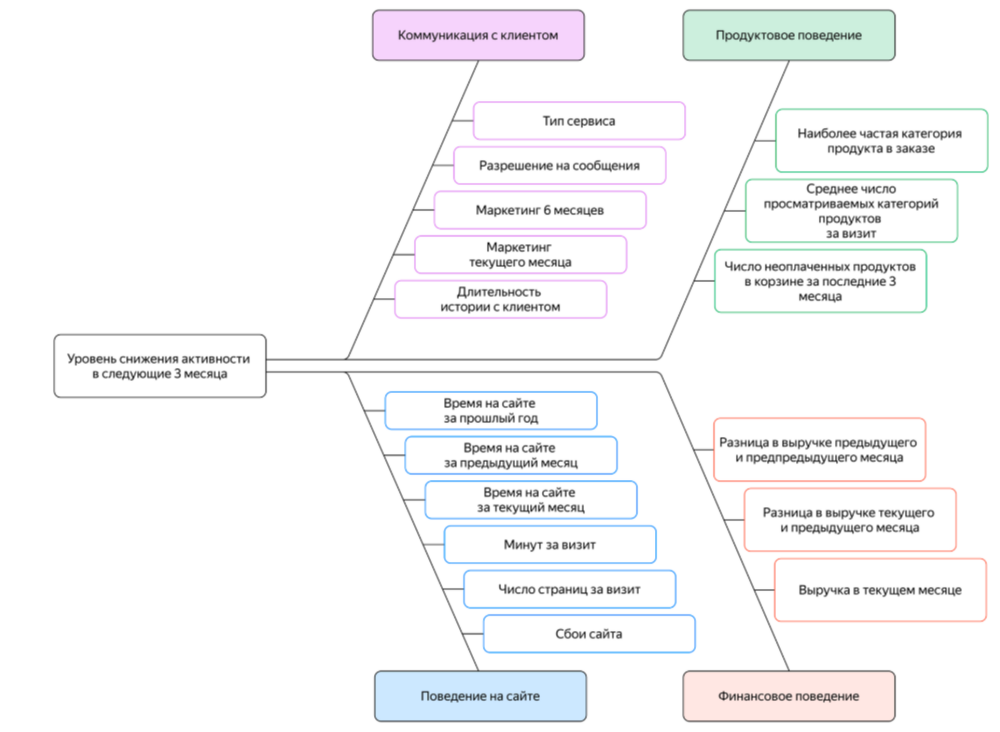



1.4. В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца;

**2) выделим сегменты покупателей и разработаем для них персонализированные предложения**, чтобы увеличить покупательскую активность, на основе данных модели и данных о прибыльности клиентов.



# **Этап 1. Загрузка данных**

Загрузим данные и обратим внимание: в некоторых файлах разделитель значений — точка с запятой, а разделитель десятичных значений — запятая.  

In [7]:
try:
    market_file_df = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv', sep=',')
    market_money_df = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv', sep=',')
    market_time_df = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv', sep=',')
    money_df = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', sep=';')
except:
    market_file_df = pd.read_csv('C:/Users/dmi-a/OneDrive/Рабочий стол/DS учеба/datasets/market_file.csv', sep=',')
    market_money_df = pd.read_csv('C:/Users/dmi-a/OneDrive/Рабочий стол/DS учеба/datasets/market_money.csv', sep=',')
    market_time_df = pd.read_csv('C:/Users/dmi-a/OneDrive/Рабочий стол/DS учеба/datasets/market_time.csv', sep=',')
    money_df = pd.read_csv('C:/Users/dmi-a/OneDrive/Рабочий стол/DS учеба/datasets/money.csv', sep=';')

## **1.1. Описание данных**

### * **market_file.csv**

Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.

In [8]:
market_file_df.head(6)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.40,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.40,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.90,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.20,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.10,3,1064,0.94,Товары для детей,3,2,3,2
5,215353,Снизилась,стандартт,да,3.30,4,762,0.26,Домашний текстиль,4,1,1,4



- **id** — номер покупателя в корпоративной базе данных.
- **Покупательская активность** — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
- **Тип сервиса** — уровень сервиса, например «премиум» и «стандарт».
- **Разрешить сообщать** — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- **Маркет_актив_6_мес** — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- **Маркет_актив_тек_мес** — количество маркетинговых коммуникаций в текущем месяце.
- **Длительность** — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- **Акционные_покупки** — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- **Популярная_категория** — самая популярная категория товаров у покупателя за последние 6 месяцев.
- **Средний_просмотр_категорий_за_визит** — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- **Неоплаченные_продукты_штук_квартал** — общее число неоплаченных товаров в корзине за последние 3 месяца.
- **Ошибка_сервиса** — число сбоев, которые коснулись покупателя во время посещения сайта.
- **Страниц_за_визит** — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

In [9]:
market_file_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

### * **market_money.csv**

Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.

In [10]:
market_money_df.sample(5)

,id,Период,Выручка
3487,216510,предыдущий_месяц,5821.00
1495,215846,препредыдущий_месяц,4956.00
244,215429,предыдущий_месяц,3662.00
1759,215934,текущий_месяц,5773.80
57,215367,препредыдущий_месяц,4668.00


- **id** — номер покупателя в корпоративной базе данных.
- **Период** — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
- **Выручка** — сумма выручки за период.

In [11]:
market_money_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


### * **market_time.csv**

Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.

In [12]:
market_time_df.sample(6)

,id,Период,минут
1996,216346,предыдцщий_месяц,15
1578,216137,предыдцщий_месяц,10
2174,216435,предыдцщий_месяц,11
643,215669,предыдцщий_месяц,8
66,215381,текущий_месяц,9
804,215750,предыдцщий_месяц,13



- **id** — номер покупателя в корпоративной базе данных.
- **Период** — название периода, во время которого зафиксировано общее время.
- **минут** — значение времени, проведённого на сайте, в минутах.

In [13]:
market_time_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


### * **money.csv**

Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

In [14]:
money_df.sample(5)

,id,Прибыль
509,215857,"4,77"
549,215897,"6,24"
102,215450,"2,93"
366,215714,"4,85"
1039,216387,"4,89"


- **id** — номер покупателя в корпоративной базе данных.
- **Прибыль** — значение прибыли.

In [15]:
money_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   Прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


## **1.2. Предварительный итог знакомства с данными**

1)  В таблице market_file_df требуется:
- добавить нижнее подчеркивание в названии трех столбцов.
- заменить опечатку в столбце "Тип сервиса" значение "стандартт" => "стандарт"

2) В таблице market_time_df требуется заменить опечатку "предыдцщий_месяц" => "предыдущий_месяц"
3) В таблице money_df требуется заменить дробный разделитель в столбце выручки.

# **Этап 2. EDA: Предобработка данных**

Создадим словарь датафреймов на всякий случай для итераций для удобства и автоматизации однотипных для разных наборов данных.

In [16]:
df_dict = {'market_file_df': market_file_df, 
            'market_money_df': market_money_df, 
            'market_time_df': market_time_df, 
            'money_df': money_df}

Начнем потихоньку собирать пайплан

Создадим сразу класс для пайплайна для переименовывания столбцов предобработки данных и исправления выявленных замечаний.

Для предобработки данных и повышения качества данных до разделения датасета на выборки находим целесообразным использовать один метод fit_transform(), так как предобработка производится до разделения на выборки.

In [17]:
class ColumnRenamer(BaseEstimator, TransformerMixin):
    """Переименовывает столбцы. Чтобы sklearn не путал местами списки с корректными и некорректными значениями, передавать их нужно в том же порядке во всех функциях и методах, особенно в виде кортежей."""

    def __init__(self, incorrect_names: List[str], correct_names: List[str]):
        if len(correct_names) != len(incorrect_names):
            raise ValueError('Длины списков не совпадают')
        
        self.incorrect_names = incorrect_names
        self.correct_names = correct_names

    def __repr__(self):
        """Контролирует и изменяет порядок вывода аргументов. По умолчанию в sklearn параметры выводятся в алфавитном порядке, из-за чего присваивались они неправильно наоборот correct_names и incorrect_names"""
        return f"ColumnRenamer(incorrect_names={self.incorrect_names}, correct_names={self.correct_names})"
        

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        print('- Переименовываю значения\n')
        df_transformed = X.copy()
        
        # Отладочная информация
        print(f"Исходные столбцы: {list(df_transformed.columns)}")
        print(f"Ищу столбцы: {self.incorrect_names}")
        
        rename_dict = {str(old): str(new) for old, new in zip(self.incorrect_names, self.correct_names)}
        print(f"Словарь переименования: {rename_dict}")
        
        # Проверяем, какие столбцы действительно есть
        existing_cols = [col for col in self.incorrect_names if col in df_transformed.columns]
        print(f"Найденные столбцы для переименования: {existing_cols}")
        
        df_transformed = df_transformed.rename(columns=rename_dict)
        print(f"Столбцы после переименования: {list(df_transformed.columns)}\n")
        
        return df_transformed

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [18]:
class DecimalPointChanger(BaseEstimator, TransformerMixin):
    """Класс для замены разделителя дроби в строковых столбцах"""

    def __init__(self, columns=None):
        """Инициализация заменщика дроби в строковых столбцах"""
        self.columns = columns  # список столбцов, в которых нужно заменить разделитель дроби
    
    def fit_transform(self, df, y=None):
        """Непосредственно заменяет разделитель дроби запятую на точку"""
        print('- Определяю необходимость замены запятой на точку')
        
        for col in self.columns:
            if col in df.columns:
                df[col] = df[col].str.replace(',', '.').astype(float)
                print('- Заменил запятую на точку')
                print(f'--- Значения в столбце {col}: {df[col].unique()}\n')
            else:
                print(f'- Ничего не заменил, все в порядке.\n')                
      
        return df


In [19]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    """Класс для удаления выбросов из данных методом IQR"""

    def __init__(self, columns=None, factor=1.5):
        """Инициализация удалителя выбросов. Есть возможность указать столбцы, в которых убирать выбросы. По умолчанию размер услов 1.5 квартиля"""
        self.columns = columns
        self.factor = factor
        self.bounds_ = {}  # для хранения границ выбросов


    def fit_transform(self, df, y=None):
        """Обучает удалитель выбросов - описывает размер квантилей и границы усов. Удаляет выбросы"""
        print('- Определяю границы выбросов методом IQR')
        
        df_transformed = df.copy()
        cols_to_process = self.columns if self.columns else df_transformed.select_dtypes(include=[np.number]).columns
        
        print(f'- Обрабатываю столбцы:')
        
        for col in cols_to_process:
            if col in df_transformed.columns:
                Q1 = df_transformed[col].quantile(0.25)
                Q3 = df_transformed[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - self.factor * IQR
                upper_bound = Q3 + self.factor * IQR
                self.bounds_[col] = (lower_bound, upper_bound)

        print('- Выполняю удаление выбросов\n')
        
        for col, (lower_bound, upper_bound) in self.bounds_.items():
            if col in df_transformed.columns:
                outliers = (df_transformed[col] < lower_bound) | (df_transformed[col] > upper_bound)
                df_transformed = df_transformed[~outliers]
                
        return df_transformed

In [20]:
class MissingValueHandler(BaseEstimator, TransformerMixin):
    """Класс для обработки пропущенных значений в данных."""

    def __init__(self, strategy='mean', fill_value=None):
        """Инициализация обработчика пропущенных значений. По умолчанию заполняет средним значением.
        """
        self.strategy = strategy
        self.fill_value = fill_value
        self.fill_values_ = {}  # для хранения значений для заполнения


    def fit_transform(self, df, y=None):
        """Заполняет пропущенные значения в тестовой выборке."""
        
        if self.strategy == 'mean':
            self.fill_values_ = df.select_dtypes(include=[np.number]).mean().to_dict() # словарь средних значений для каждого числового столбца
        elif self.strategy == 'median':
            self.fill_values_ = df.select_dtypes(include=[np.number]).median().to_dict()
        elif self.strategy == 'mode':
            self.fill_values_ = {}
            for col in df.columns:
                self.fill_values_[col] = df[col].value_counts().index[0]

        print('- Определяю методы заполнения пропусков\n')
        for col, fill_value in self.fill_values_.items():
             if col in df.columns:
                if df[col].isnull().sum() > 0:
                    print(f'- В колонке {col} {df[col].isnull().sum()} пропусков. Заполняю пропуски\n')
                    df[col] = df[col].fillna(fill_value)

        return df

In [21]:
class MissingRemover(BaseEstimator, TransformerMixin):
    """Класс для удаления строк с пропущенными значениями, по умолчанию axis=0, но можно поменять на 1 для столбцов"""

    def __init__(self, columns=None, axis=0):
        """Инициализация удаления строк с пропущенными значениями"""
        self.columns = columns
        self.axis = axis

    def fit_transform(self, df, y=None):
        """Удаляет строки с пропущенными значениями"""
        print('- Выполняю удаление строк с пропущенными значениями\n')
        
        if self.columns:
            return df.dropna(subset=self.columns, axis=self.axis)
        else:
            return df.dropna(axis=self.axis)   


In [22]:
class MistakeCorrector(BaseEstimator, TransformerMixin):
    """Класс для исправления опечаток в данных."""

    def __init__(self, columns: List[str], values_dict: dict):
        """Инициализация исправителя опечаток. Принимает словарь с правильными значениями."""
        self.values_dict = values_dict
        self.columns = columns

    def fit_transform(self, df, y=None):
        """Исправляет опечатки в данных"""
        print('- Выполняю исправление опечаток\n')
        
        df_transformed = df.copy()
        
        for col in self.columns:
            if col in df_transformed.columns:
                for incorrect_value, correct_value in self.values_dict.items():
                    df_transformed[col] = df_transformed[col].replace(incorrect_value, correct_value)
        
        return df_transformed

In [23]:
class DuplicateRemover(BaseEstimator, TransformerMixin):
    """Класс для удаления дубликатов"""

    def __init__(self, columns=None):
        """Инициализация удалителя дубликатов"""
        self.columns = columns

    def fit(self, df, y=None):
        return self

    def transform(self, df, y=None):
        """Удаляет дубликаты"""

        duplicate_count = df.duplicated().sum()

        if duplicate_count:
            print(f'- Выявлено {duplicate_count} дубликатов')
            print('- Выполняю удаление дубликатов\n')

            if self.columns:
                df = df.drop_duplicates(subset=self.columns)                
            else:
                df = df.drop_duplicates()

        

        remaining_duplicates = df.duplicated().sum()
        print(f'- Осталось {remaining_duplicates} дубликатов\n')
        return df
            
    
    def fit_transform(self, df, y=None):
        return self.fit(df, y).transform(df)
                

In [24]:
class ImplicitDuplicatesViewer(BaseEstimator, TransformerMixin):
    """Выводит уникальные значения каждого столбца для визуального определения неявных дубликатов"""

    def __init__(self, columns=None):
        """Инициализация определеителя неявных дуликатов"""
        self.columns = columns


    def fit(self, df, y=None):
        return self


    def transform(self, df, y=None):
        """Выводит уникальные значения каждого столбца для визуального определения неявных дуликатов"""

        print('- Выполняю поиск неявных дубликатов в нечисловых столбцах\n')

        if self.columns:
            for col in self.columns:
                if col in df.columns:
                    print(f'- Уникальные значения в столбце {col}: {df[col].unique()}\n')
            return df
        else: 
            columns = df.select_dtypes(exclude=[np.number]).columns
            for col in columns:
                print(f'- Уникальные значения в столбце {col}: {df[col].unique()}\n')
            return df
        
    def fit_transform(self, df, y=None):
        return self.fit(df, y).transform(df)

In [25]:
class Preprocessor:
    """
    Основной класс пайплайна для предобработки данных
    """

    def __init__(self):
        self.steps = []  # список шагов предобработки, которые будут выполняться в пайплайне
        self.fitted_transformers = {}  # для хранения обученных трансформеров (запоминает что-то и делает)


    def add_column_renamer(self, incorrect_names: List[str], correct_names: List[str]):
        """Добавляет шаг переименовывания  столбцов в пайплайн"""
        renamer = ColumnRenamer(incorrect_names, correct_names)
        self.steps.append(('column_renamer', renamer))
        return self
    

    def add_missing_value_handler(self, strategy='mean', fill_value=None, step_name='missing_handler'):
        """Добавляет обработчик пропущенных значений в препроцессор"""
        handler = MissingValueHandler(strategy=strategy, fill_value=fill_value)
        self.steps.append((step_name, handler))
        return self
    

    def add_mistake_corrector(self, columns: List[str], values_dict: dict[str], step_name='mistake_corrector'):
        """Добавляет шаг исправления опечаток в препроцессор, принимает на вход список колонок, в которых произвести замены, словарь с неверными и верными значениями"""
        mistake_corrector = MistakeCorrector(columns=columns, values_dict=values_dict)
        self.steps.append((step_name, mistake_corrector))
        return self
    

    def add_outlier_remover(self, step_name='outlier_remover'):
        '''Добавляет шаг удаления выбросов в препроцессор'''
        outlier_remover = OutlierRemover()
        self.steps.append((step_name, outlier_remover))
        return self
    

    def add_decimal_point_changer(self, columns: List[str], step_name='decimal_point_changer'):
        """Добавляет шаг замены десятичного разделителя в препроцессор"""
        decimal_point_changer = DecimalPointChanger(columns)
        self.steps.append((step_name, decimal_point_changer))
        return self
    
    def add_drop_duplicates(self, step_name='drop_duplicates'):
        """Добавляет шаг удаления дуликатов"""
        duplicate_remover = DuplicateRemover()
        self.steps.append((step_name, duplicate_remover))
        return self
    

    def add_implicit_duplicates_viewer(self, step_name='implicit_duplicates_viewer'):
        """Добавляет шаг отображения уникальных значений каждого столбца для выявления неявных дуликатов визуально."""
        implict_duplicates_viewer = ImplicitDuplicatesViewer()
        self.steps.append((step_name, implict_duplicates_viewer))
        return self
    

    def add_custom_transformer(self, step_name: str, transformer):
        """Добавляет пользовательский трансформер в пайплан предобраотки"""
        self.steps.append((step_name, transformer))
        return self
    

    def fit_transform(self, df, y=None):
        """Обучает все трансформеры пайплайна (запоминает единые параметры и условия исполнения - консистентность). Принимает df и целевую переменную опционально."""

        for i, (step_name, transformer) in enumerate(self.steps):
            print(f'Исполнение шага {i+1}: {step_name}')
            df = transformer.fit_transform(df)
            self.fitted_transformers[step_name] = transformer
            # df = transformer.transform(df)
        return df


## **2.1. Исправление выявленных замечаний**

In [26]:
Preprocessor_pipeline = (
    Preprocessor()
    .add_column_renamer(incorrect_names=['Покупательская активность', 'Тип сервиса', 'Разрешить сообщать'], correct_names=['Покупательская_активность', 'Тип_сервиса', 'Разрешить_сообщать'])
    .add_decimal_point_changer(columns=['Прибыль'])
    .add_missing_value_handler(strategy='mode')
    .add_mistake_corrector(columns=['Тип_сервиса', 'Период'], values_dict={'предыдцщий_месяц': 'предыдущий_месяц',
                                                    'стандартт': 'стандарт'})
    .add_drop_duplicates()
    .add_implicit_duplicates_viewer()
    # .add_outlier_remover() # он удаляет 762 строки выбросы удалять не надо, как оказалось
)

print('Вот такким у нас получился предобработчки данных.')

print("Шаги в пайплайне:")
for i, (name, step) in enumerate(Preprocessor_pipeline.steps):
    print(f"{i+1}. {name}: {step}\n")

Вот такким у нас получился предобработчки данных.
Шаги в пайплайне:
1. column_renamer: ColumnRenamer(incorrect_names=['Покупательская активность', 'Тип сервиса', 'Разрешить сообщать'], correct_names=['Покупательская_активность', 'Тип_сервиса', 'Разрешить_сообщать'])

2. decimal_point_changer: DecimalPointChanger(columns=['Прибыль'])

3. missing_handler: MissingValueHandler(strategy='mode')

4. mistake_corrector: MistakeCorrector(columns=['Тип_сервиса', 'Период'],
                 values_dict={'предыдцщий_месяц': 'предыдущий_месяц',
                              'стандартт': 'стандарт'})

5. drop_duplicates: DuplicateRemover()

6. implicit_duplicates_viewer: ImplicitDuplicatesViewer()



Исполним препроцессор по предобработке данных.

Исправим выявленные замечания.

In [27]:
for name, df in df_dict.items():
    print('=' * 50)
    print(f' =>  Обработка датафрейма {name}')
    print('=' * 50)
    df_dict[name] = Preprocessor_pipeline.fit_transform(df)
    globals()[name] = df_dict[name]  # Перезаписывает глобальную переменную
    print(f'Проверка датафрейма {name}')
    display(df_dict[name].head())

 =>  Обработка датафрейма market_file_df
Исполнение шага 1: column_renamer
- Переименовываю значения

Исходные столбцы: ['id', 'Покупательская активность', 'Тип сервиса', 'Разрешить сообщать', 'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Популярная_категория', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит']
Ищу столбцы: ['Покупательская активность', 'Тип сервиса', 'Разрешить сообщать']
Словарь переименования: {'Покупательская активность': 'Покупательская_активность', 'Тип сервиса': 'Тип_сервиса', 'Разрешить сообщать': 'Разрешить_сообщать'}
Найденные столбцы для переименования: ['Покупательская активность', 'Тип сервиса', 'Разрешить сообщать']
Столбцы после переименования: ['id', 'Покупательская_активность', 'Тип_сервиса', 'Разрешить_сообщать', 'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Популярная_категория', 'Средний_просмотр_категорий_за_ви

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.40,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.40,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандарт,нет,4.90,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандарт,да,3.20,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандарт,нет,5.10,3,1064,0.94,Товары для детей,3,2,3,2


 =>  Обработка датафрейма market_money_df
Исполнение шага 1: column_renamer
- Переименовываю значения

Исходные столбцы: ['id', 'Период', 'Выручка']
Ищу столбцы: ['Покупательская активность', 'Тип сервиса', 'Разрешить сообщать']
Словарь переименования: {'Покупательская активность': 'Покупательская_активность', 'Тип сервиса': 'Тип_сервиса', 'Разрешить сообщать': 'Разрешить_сообщать'}
Найденные столбцы для переименования: []
Столбцы после переименования: ['id', 'Период', 'Выручка']

Исполнение шага 2: decimal_point_changer
- Определяю необходимость замены запятой на точку
- Ничего не заменил, все в порядке.

Исполнение шага 3: missing_handler
- Определяю методы заполнения пропусков

Исполнение шага 4: mistake_corrector
- Выполняю исправление опечаток

Исполнение шага 5: drop_duplicates
- Осталось 0 дубликатов

Исполнение шага 6: implicit_duplicates_viewer
- Выполняю поиск неявных дубликатов в нечисловых столбцах

- Уникальные значения в столбце Период: ['препредыдущий_месяц' 'текущий_мес

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.00
1,215348,текущий_месяц,3293.10
2,215348,предыдущий_месяц,0.00
3,215349,препредыдущий_месяц,4472.00
4,215349,текущий_месяц,4971.60


 =>  Обработка датафрейма market_time_df
Исполнение шага 1: column_renamer
- Переименовываю значения

Исходные столбцы: ['id', 'Период', 'минут']
Ищу столбцы: ['Покупательская активность', 'Тип сервиса', 'Разрешить сообщать']
Словарь переименования: {'Покупательская активность': 'Покупательская_активность', 'Тип сервиса': 'Тип_сервиса', 'Разрешить сообщать': 'Разрешить_сообщать'}
Найденные столбцы для переименования: []
Столбцы после переименования: ['id', 'Период', 'минут']

Исполнение шага 2: decimal_point_changer
- Определяю необходимость замены запятой на точку
- Ничего не заменил, все в порядке.

Исполнение шага 3: missing_handler
- Определяю методы заполнения пропусков

Исполнение шага 4: mistake_corrector
- Выполняю исправление опечаток

Исполнение шага 5: drop_duplicates
- Осталось 0 дубликатов

Исполнение шага 6: implicit_duplicates_viewer
- Выполняю поиск неявных дубликатов в нечисловых столбцах

- Уникальные значения в столбце Период: ['текущий_месяц' 'предыдущий_месяц']

Пр

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдущий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдущий_месяц,12
4,215350,текущий_месяц,13


 =>  Обработка датафрейма money_df
Исполнение шага 1: column_renamer
- Переименовываю значения

Исходные столбцы: ['id', 'Прибыль']
Ищу столбцы: ['Покупательская активность', 'Тип сервиса', 'Разрешить сообщать']
Словарь переименования: {'Покупательская активность': 'Покупательская_активность', 'Тип сервиса': 'Тип_сервиса', 'Разрешить сообщать': 'Разрешить_сообщать'}
Найденные столбцы для переименования: []
Столбцы после переименования: ['id', 'Прибыль']

Исполнение шага 2: decimal_point_changer
- Определяю необходимость замены запятой на точку
- Заменил запятую на точку
--- Значения в столбце Прибыль: [0.98 4.16 3.13 4.87 4.21 3.95 3.62 5.26 4.93 4.66 3.06 5.08 4.55 4.03
 3.49 1.83 2.67 3.65 2.95 3.03 6.27 3.86 2.82 1.4  1.63 3.69 4.08 4.18
 4.26 4.27 4.42 3.88 2.42 4.78 4.85 4.05 3.48 5.16 4.6  5.7  5.44 4.1
 2.93 3.9  3.28 5.09 3.19 4.77 5.01 6.73 7.43 4.28 3.73 3.38 3.47 5.
 2.02 3.68 2.68 4.46 2.41 5.4  3.4  4.22 4.5  4.98 3.96 3.18 4.65 3.92
 3.89 5.64 2.76 4.25 3.71 4.63 2.97 3.2

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


## **2.2. Промежуточный итог**

1)  В таблице **market_file_df**:
- добавили нижнее подчеркивание в названии трех столбцов.
- заменили опечатку в столбце "Тип сервиса" значение "стандартт" => "стандарт"

2) В таблице **market_time_df** заменили опечатку "предыдцщий_месяц" => "предыдущий_месяц"
3) В таблице **money_df** заменили дробный разделитель с запятой на точку в столбце выручки.

# **Этап 3. Исследовательский анализ данных**

Проведем EDA (исследовательский анализ данных) из каждой таблицы.

## **3.1. Профайлинг данных**

Это комплексное быстрое представление о качестве данных и их зависимостях. 

(можно прокручивать вниз в рамках ячейки)

In [28]:
# for name, df in df_dict.items():    # в Яндексе не работает происходит бесконечный конфликт библиотек
#     print(f'\n=== {name.upper()} ===')
#     print(f'Описательная статистика:')
#     display(df.describe())
#     profile = ProfileReport(df)
#     display(profile.to_notebook_iframe())

## **3.1. Ключевые выводы из статистики:**

<U>**Наибольшие корреляции:**</U>

**Прямая корреляция**
- [Тип сервиса] и [Длительность регистрации];
- [Покупательская активность] и [Страниц за визит];
- [Покупательская активность] и [Неоплаченные продукты штук за квартал];
- [Покупательская активность] и [Актив за 6 месяцев];

**Обратная корреляция**
- [Акционные покупки] и [Страниц за визит]


🔍 <U>**Маркетинговая активность:**</U>

- **Среднее значение:** 4.38 коммуникаций за 6 месяцев
- **Текущий месяц:** стабильно 4.0 у всех клиентов
**Вывод:** Умеренная маркетинговая нагрузка немного снизилась, есть потенциал для увеличения


👥 <U>**Клиентская база:**</U>

- **Наибольший сегмент по [типу сервиса]:** стандарт
- **Длительность регистрации:** средний срок жизни клиента 601 день (~1.6 года)
- **Разброс:** от 4 месяцев до 3 лет
**Вывод:** Зрелая клиентская база с хорошим retention


🛒 <U>**Покупательское поведение:**</U>

- **Самая популярная категория товаров:** Товары для детей
- **Акционные покупки:** 23% от всех покупок
- **Неоплаченные товары:** в среднем 2.76 штук в квартал
**Вывод:** Клиенты умеренно реагируют на акции, есть проблемы с конверсией корзины


🌐 <U>**Поведение на сайте:**</U>

- **Просмотр категорий:** 3.31 за визит
- **Страниц за визит:** 8.8 страниц
- **Ошибки сервиса:** 4.17 в среднем
**Вывод:** Активное исследовательское поведение, но высокий уровень технических проблем


<U>**Рекомендации:**</U>
- Снизить технические ошибки (4+ ошибок критично)
- Оптимизировать конверсию корзины (2.76 неоплаченных товаров)
- Персонализировать маркетинг на основе категорий интересов
- Увеличить долю акционных предложений для активных пользователей


⚠️ <U>**Риски:**</U>
- Высокий уровень технических проблем может снижать лояльность
- Большое количество неоплаченных товаров указывает на проблемы UX

## **3.2. Анализ выручки интернет-магазина**

Основные показатели

In [29]:
revenue = market_money_df.pivot_table(index='Период', values='Выручка', aggfunc=['sum', 'mean', 'count']).sort_values(('count','Выручка'), ascending=False)
revenue

,sum,mean,count
,Выручка,Выручка,Выручка
Период,,,
предыдущий_месяц,6417996.50,4936.92,1300
препредыдущий_месяц,6272769.00,4825.21,1300
текущий_месяц,6909449.10,5314.96,1300


Основной график

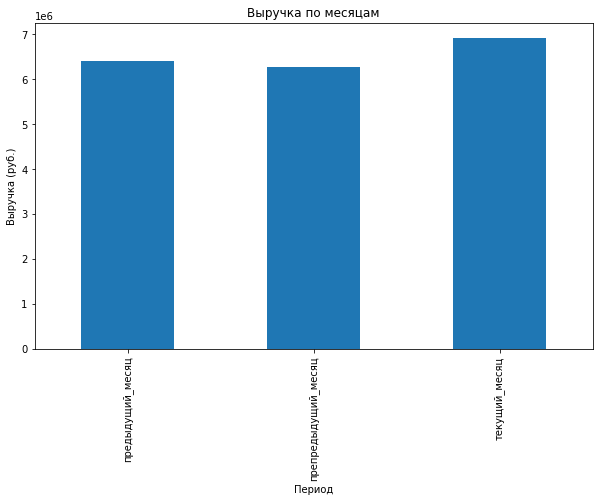

In [30]:
revenue[('sum', 'Выручка')].plot(kind='bar', figsize=(10, 6), title='Выручка по месяцам')
plt.ylabel('Выручка (руб.)')
plt.xlabel('Период')
# plt.savefig('revenue_chart.png', dpi=300, bbox_inches='tight')
plt.show()



📊 **Ключевые показатели выручки:**</U>

- **Выручка у Интернет-магазина падает** с каждым месяцем;
- Средняя выручка на человека растет;
- Но **количество покупателей сокращается еще быстрее**, за счет этого средняя выручка выше

💵 **Средняя выручка с клиента:** 4,982 руб. за период взаимодействия

- **Медиана:** 4,952 руб. (близко к среднему - хорошее распределение)
- **Диапазон:** от 3,432 до 6,518 руб.


📈 <U>**Распределение клиентов:**</U>

- **25% клиентов** тратят менее 4,599 руб.
- **50% клиентов** тратят 4,599-5,334 руб. (основная масса)
- **25% клиентов** тратят более 5,334 руб. (VIP-сегмент)


✅ <U>**Позитивные моменты:**</U>

- Стабильная монетизация клиентской базы
- Умеренный разброс значений (CV = 11.5%) - предсказуемая выручка
- Отсутствие экстремальных выбросов


⚠️ <U>**Возможности для роста:**</U>

- **Потенциал увеличения:** разница между топ-25% и средним сегментом составляет ~350 руб.
- **Up-sell возможности:** 75% клиентов тратят менее 5,334 руб.


🚀 <U>**Рекомендации по увеличению выручки:**</U>

**Сегментация клиентов:**

- **Низкий чек** (<4,599): стимулирование покупок
- **Средний чек** (4,599-5,334): cross-sell программы
- **Высокий чек** (>5,334): VIP-программы лояльности

**Целевые показатели:**

- Поднять средний чек до 5,200-5,500 руб.
- Увеличить долю клиентов с чеком >5,334 руб. до 35-40%

<U>**Тактики:**</U>

- Персонализированные рекомендации для среднего сегмента
- Программы лояльности для топ-клиентов
- Стимулирование повторных покупок

💡 <U>**Потенциал роста выручки:**</U>

 +10-15% при правильной сегментации

##  **3.3. Анализ времени на сайте**

🕐 <U>**Среднее время на сайте:**</U>

13.34 минуты за период

- **Медиана**: 13 минут (идеально совпадает со средним)
- **Диапазон**: от 4 до 23 минут

📈 <U>**Распределение пользователей:**</U>
- **25% пользователей** проводят менее 10 минут (быстрые покупки)
- **50% пользователей** проводят 10-16 минут (основная масса)
- **25% пользователей** проводят более 16 минут (исследователи)

🎯 <U>**Поведенческие выводы:**</U>

✅ **Позитивные сигналы:**
- Высокая вовлеченность: 13+ минут - отличный показатель для e-commerce
- Стабильное распределение: низкое стандартное отклонение (4.08)
- Отсутствие "отказников": минимум 4 минуты

🔍 <U>**Сегментация по времени:**</U>

- **Быстрые покупатели** (<10 мин): знают что хотят, целенаправленные
- **Обычные покупатели** (10-16 мин): изучают ассортимент, сравнивают
- **Исследователи** (>16 мин): детально изучают, возможно нерешительные, сомневаются

🚀 <U>**Стратегические рекомендации:**</U>

**Для быстрых покупателей (<10 мин):**
- Упростить процесс покупки
- Быстрый доступ к популярным товарам
- One-click покупки

**Для исследователей (>16 мин):**
- Персональные консультанты/чат-боты
- Детальные сравнения товаров
- Программы лояльности

**Общие улучшения:**</U>

- Оптимизировать UX для удержания среднего времени ~15 минут
- A/B тестировать элементы для увеличения конверсии

💡 <U>**Вывод:**</U> Пользователи активно взаимодействуют с сайтом, что создает хорошие возможности для персонализации и увеличения продаж

# **Этап 4. Объединение таблиц**

## **4.1 Объединие таблиц**

* market_file.csv, 
* market_money.csv, 
* market_time.csv.

Данные о прибыли из файла money.csv при моделировании нам не понадобятся.

Но данные о прибыли понядобятся при сегментации. 

Поэтому, мы сейчас данные о прибыли присоединим, но перед моделированием удалим.

**В market_file_df ничего пивотировать не нужн (нечего и все айди уникальные)**


In [31]:
market_file_df

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.40,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.40,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандарт,нет,4.90,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандарт,да,3.20,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандарт,нет,5.10,3,1064,0.94,Товары для детей,3,2,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,216643,Прежний уровень,стандарт,да,6.60,3,318,0.24,Техника для красоты и здоровья,5,3,3,11
1296,216644,Прежний уровень,стандарт,нет,5.10,4,454,0.21,Домашний текстиль,6,2,3,9
1297,216645,Прежний уровень,стандарт,да,4.10,3,586,0.20,Домашний текстиль,3,2,5,7
1298,216646,Прежний уровень,стандарт,да,6.30,5,645,0.12,Техника для красоты и здоровья,3,3,5,7


In [32]:
df['id'].nunique()

1300

**в market_money_df нужно пивотировать период**


In [33]:
market_money_df = market_money_df.pivot_table(index='id', columns='Период', values='Выручка')
market_money_df.columns.name = None
market_money_df = market_money_df.reset_index()
market_money_df.columns = ['id', 'Выручка_предыдущий_месяц', 'Выручка_препредыдущий_месяц', 'Выручка_текущий_месяц']
market_money_df

,id,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц
0,215348,0.00,0.00,3293.10
1,215349,5216.00,4472.00,4971.60
2,215350,5457.50,4826.00,5058.40
3,215351,6158.00,4793.00,6610.40
4,215352,5807.50,4594.00,5872.50
...,...,...,...,...
1295,216643,3664.00,4704.00,4741.70
1296,216644,4729.00,5299.00,5353.00
1297,216645,5160.00,5334.00,5139.20
1298,216646,4923.00,4725.00,5224.60


**Отеберем только активных пользователей: необходимые 1297 пользователей**

Для этого нужно найти тех, у кого стоит 0 по выручке в любой из трех месяцев - и удалить их. Но таких пользователей нет.

In [34]:
market_money_df = market_money_df[(market_money_df != 0).all(axis=1)]

In [35]:
df = pd.merge(market_money_df, market_file_df, on='id', how='left') 
df.head()

,id,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215349,5216.00,4472.00,4971.60,Снизилась,премиум,да,4.40,4,819,0.75,Товары для детей,4,4,2,5
1,215350,5457.50,4826.00,5058.40,Снизилась,стандарт,нет,4.90,3,539,0.14,Домашний текстиль,5,2,1,5
2,215351,6158.00,4793.00,6610.40,Снизилась,стандарт,да,3.20,5,896,0.99,Товары для детей,5,0,6,4
3,215352,5807.50,4594.00,5872.50,Снизилась,стандарт,нет,5.10,3,1064,0.94,Товары для детей,3,2,3,2
4,215353,4738.50,5124.00,5388.50,Снизилась,стандарт,да,3.30,4,762,0.26,Домашний текстиль,4,1,1,4


In [36]:
df.shape

(1297, 16)

Первые две таблицы соединили успешно.

**Пивотируем market_time_df**

In [37]:
market_time_df = market_time_df.pivot_table(index='id', columns='Период', values='минут')
market_time_df.columns.name = None
market_time_df = market_time_df.reset_index()
market_time_df.columns = ['id', 'минут_предыдущий_месяц', 'минут_препредыдущий_месяц']
market_time_df


,id,минут_предыдущий_месяц,минут_препредыдущий_месяц
0,215348,13,14
1,215349,12,10
2,215350,8,13
3,215351,11,13
4,215352,8,11
...,...,...,...
1295,216643,14,7
1296,216644,12,11
1297,216645,12,18
1298,216646,18,7


In [38]:
df = pd.merge(df, market_time_df, on='id', how='left') 
df.head()

,id,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,минут_предыдущий_месяц,минут_препредыдущий_месяц
0,215349,5216.00,4472.00,4971.60,Снизилась,премиум,да,4.40,4,819,0.75,Товары для детей,4,4,2,5,12,10
1,215350,5457.50,4826.00,5058.40,Снизилась,стандарт,нет,4.90,3,539,0.14,Домашний текстиль,5,2,1,5,8,13
2,215351,6158.00,4793.00,6610.40,Снизилась,стандарт,да,3.20,5,896,0.99,Товары для детей,5,0,6,4,11,13
3,215352,5807.50,4594.00,5872.50,Снизилась,стандарт,нет,5.10,3,1064,0.94,Товары для детей,3,2,3,2,8,11
4,215353,4738.50,5124.00,5388.50,Снизилась,стандарт,да,3.30,4,762,0.26,Домашний текстиль,4,1,1,4,10,10


In [39]:
df.shape

(1297, 18)

In [40]:
df = pd.merge(df, money_df, on='id', how='left') 
df.head()

,id,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,минут_предыдущий_месяц,минут_препредыдущий_месяц,Прибыль
0,215349,5216.00,4472.00,4971.60,Снизилась,премиум,да,4.40,4,819,0.75,Товары для детей,4,4,2,5,12,10,4.16
1,215350,5457.50,4826.00,5058.40,Снизилась,стандарт,нет,4.90,3,539,0.14,Домашний текстиль,5,2,1,5,8,13,3.13
2,215351,6158.00,4793.00,6610.40,Снизилась,стандарт,да,3.20,5,896,0.99,Товары для детей,5,0,6,4,11,13,4.87
3,215352,5807.50,4594.00,5872.50,Снизилась,стандарт,нет,5.10,3,1064,0.94,Товары для детей,3,2,3,2,8,11,4.21
4,215353,4738.50,5124.00,5388.50,Снизилась,стандарт,да,3.30,4,762,0.26,Домашний текстиль,4,1,1,4,10,10,3.95


In [41]:
df.shape

(1297, 19)

## **4.2. Разделим данные на числовые и категориальные**

Для начала чтобы потом посмотреть корреляции

In [42]:
numeric_names = df.select_dtypes(include=[np.number]).columns
categoric_names = df.select_dtypes(exclude=[np.number]).columns

## **4.3 Закодируем категориальные признаки**

* отдельный столбец для каждого периода создался после пивотирования.

**удалим id столбец из датафрейма**

* Сохраним в другой датафрейм без ['id', 'Прибыль'] для обучения модели
* Оставим в исходном датафрейме ['id', 'Прибыль'] для сегментации покупателей.

In [43]:
df_for_model = df.drop(['id', 'Прибыль'], axis=1)

# **Этап 5. Корреляционный анализ**

## **5.1. Коэффициенты корреляции**

Будем смотреть на датафрейме для обучения модели, у которого удален id из-за мультиколлениарности.
Долго считается phik_matrix

In [44]:
interval_cols = [ # только дробные числа или которые не в силах посчитать руками (длительность 762) и может иметь дробную часть
       'Маркет_актив_6_мес', 'Длительность', 'Акционные_покупки', 
       'Выручка_предыдущий_месяц', 'Выручка_препредыдущий_месяц', 'Выручка_текущий_месяц']

phik_corr = df_for_model.phik_matrix(interval_cols=interval_cols)
phik_corr         

,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,минут_предыдущий_месяц,минут_препредыдущий_месяц
Выручка_предыдущий_месяц,1.00,0.36,0.14,0.23,0.00,0.08,0.15,0.05,0.13,0.07,0.25,0.10,0.19,0.00,0.15,0.18,0.16
Выручка_препредыдущий_месяц,0.36,1.00,0.00,0.50,0.07,0.00,0.31,0.00,0.11,0.23,0.05,0.18,0.19,0.14,0.34,0.35,0.33
Выручка_текущий_месяц,0.14,0.00,1.00,0.00,0.00,0.00,0.27,0.00,0.00,0.02,0.04,0.00,0.00,0.00,0.00,0.00,0.00
Покупательская_активность,0.23,0.50,0.00,1.00,0.13,0.00,0.55,0.00,0.10,0.51,0.30,0.54,0.40,0.22,0.75,0.60,0.57
Тип_сервиса,0.00,0.07,0.00,0.13,1.00,0.29,0.09,0.04,0.40,0.03,0.07,0.19,0.11,0.08,0.09,0.12,0.06
Разрешить_сообщать,0.08,0.00,0.00,0.00,0.29,1.00,0.00,0.05,0.25,0.02,0.07,0.07,0.16,0.02,0.10,0.06,0.00
Маркет_актив_6_мес,0.15,0.31,0.27,0.55,0.09,0.00,1.00,0.08,0.00,0.28,0.15,0.21,0.22,0.15,0.37,0.32,0.33
Маркет_актив_тек_мес,0.05,0.00,0.00,0.00,0.04,0.05,0.08,1.00,0.17,0.00,0.14,0.25,0.14,0.12,0.00,0.17,0.08
Длительность,0.13,0.11,0.00,0.10,0.40,0.25,0.00,0.17,1.00,0.00,0.00,0.19,0.13,0.17,0.13,0.04,0.01
Акционные_покупки,0.07,0.23,0.02,0.51,0.03,0.02,0.28,0.00,0.00,1.00,0.12,0.20,0.25,0.00,0.35,0.31,0.29


Посмотрим коэффициенты корреляции.

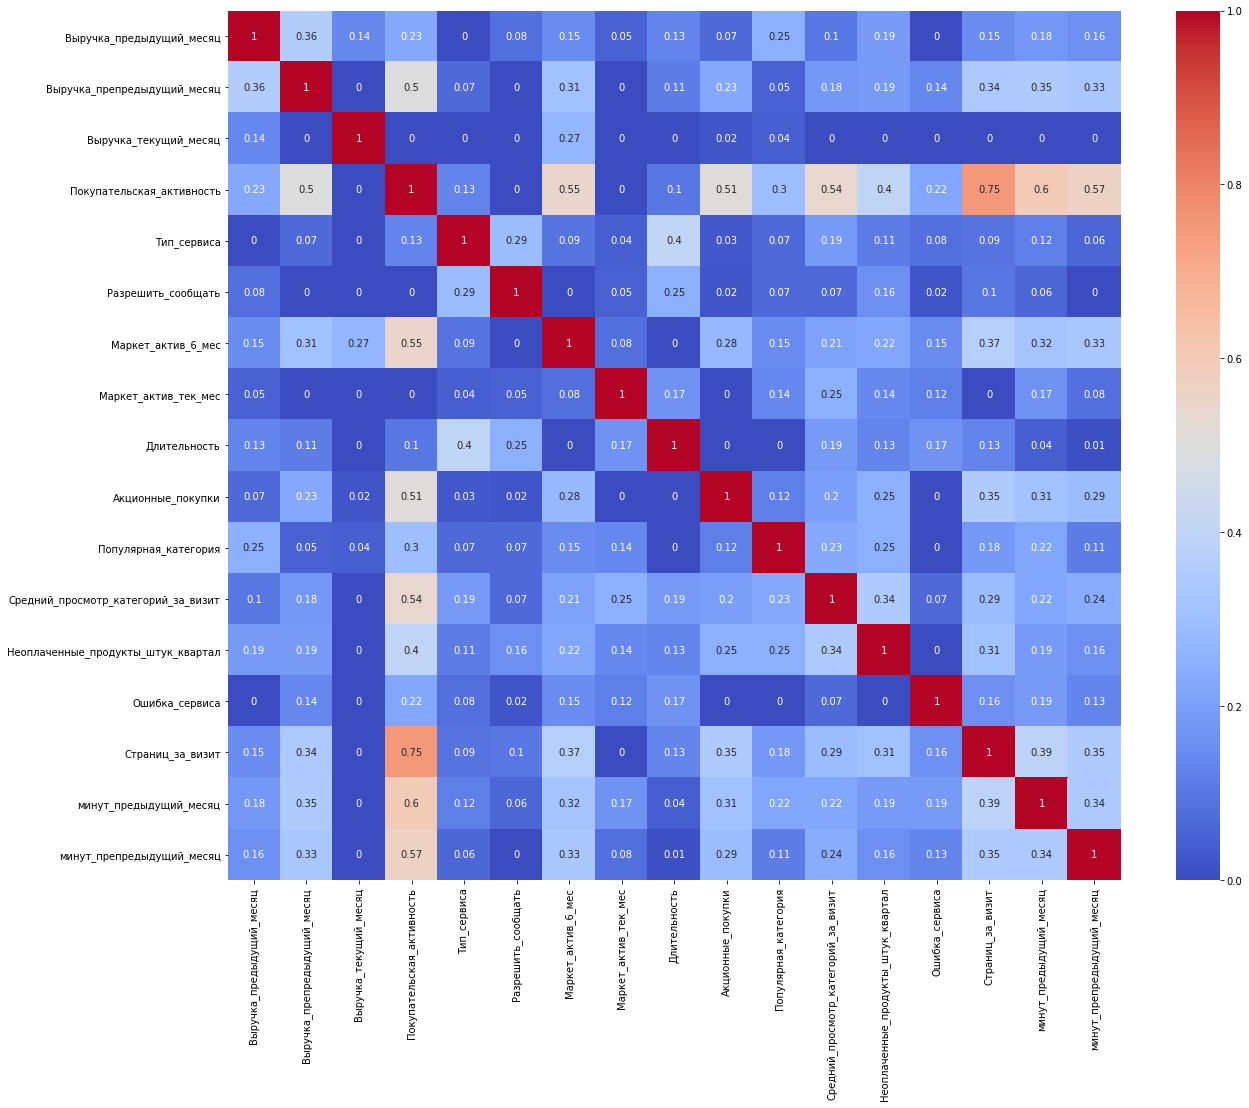

In [45]:
plt.figure(figsize=(20, 16))
sns.heatmap(phik_corr.round(2), annot=True, cmap='coolwarm')
plt.show()

## **5.2. Мультиколлинеарность**

Мультиколлениарность наблюдается с id пользователя, казалось бы, ее там нет, коэфициент всего 0.76, можно расценивать как хорошую корреляцию, а мультиколинеарность расценивать от 0.8, но id дает сильной переобучение, удалили его, да и все равно смысла в этом столбце никакого нет.

# **Этап 6. Пайплайн модели**

## **6.1. Деление на выборки**

Перед тем как создавать пайплайны, необходимо разделить на выборки.

* тренировочную
* тестовую
* валидационную

In [46]:
target = 'Покупательская_активность'

X = df_for_model.drop(columns=target)
y = df_for_model[target]

RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(
                                                    X,
                                                    y,
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE,
                                                    stratify=y
    )

In [47]:
df_for_model

,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,минут_предыдущий_месяц,минут_препредыдущий_месяц
0,5216.00,4472.00,4971.60,Снизилась,премиум,да,4.40,4,819,0.75,Товары для детей,4,4,2,5,12,10
1,5457.50,4826.00,5058.40,Снизилась,стандарт,нет,4.90,3,539,0.14,Домашний текстиль,5,2,1,5,8,13
2,6158.00,4793.00,6610.40,Снизилась,стандарт,да,3.20,5,896,0.99,Товары для детей,5,0,6,4,11,13
3,5807.50,4594.00,5872.50,Снизилась,стандарт,нет,5.10,3,1064,0.94,Товары для детей,3,2,3,2,8,11
4,4738.50,5124.00,5388.50,Снизилась,стандарт,да,3.30,4,762,0.26,Домашний текстиль,4,1,1,4,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1292,3664.00,4704.00,4741.70,Прежний уровень,стандарт,да,6.60,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,14,7
1293,4729.00,5299.00,5353.00,Прежний уровень,стандарт,нет,5.10,4,454,0.21,Домашний текстиль,6,2,3,9,12,11
1294,5160.00,5334.00,5139.20,Прежний уровень,стандарт,да,4.10,3,586,0.20,Домашний текстиль,3,2,5,7,12,18
1295,4923.00,4725.00,5224.60,Прежний уровень,стандарт,да,6.30,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,18,7


In [48]:
# X_train - тренировочная выборка для обучения модели
# y_train - целевой признак для обучения модели

# X_test - для финальной проверки качества модели
# y_test - целевой признак для финальной проверки качества модели

print("Размеры выборок:")
print(f"Train: {X_train.shape[0]} ({X_train.shape[0]/len(df)*100:.1f}%)") 
print(f"Test: {X_test.shape[0]} ({X_test.shape[0]/len(df)*100:.1f}%)")
print(f"Общий размер: {len(df)}")

# проверим распределение классов
print("\nРаспределение классов:")
print("Train:", y_train.value_counts(normalize=True).round(3))
print()
print("Test:", y_test.value_counts(normalize=True).round(3))

Размеры выборок:
Train: 972 (74.9%)
Test: 325 (25.1%)
Общий размер: 1297

Распределение классов:
Train: Прежний уровень   0.62
Снизилась         0.38
Name: Покупательская_активность, dtype: float64

Test: Прежний уровень   0.62
Снизилась         0.38
Name: Покупательская_активность, dtype: float64


## **6.2. Масштабируем и категорируем**

Создадим пайплайн для подготовки данных к обучению:
* Кодируем категориальные признаки;
* Масштабируем количественные признаки;

Создадим пайплайн с использованием ColumnTransformer.

In [49]:
# Разделяем категориальные признаки
numeric_features = X.select_dtypes(include=[np.number]).columns
ordinal_features = ['Тип_сервиса', 'Разрешить_сообщать']  # стандарт < премиум
nominal_features = ['Популярная_категория']  # неупорядоченные

In [50]:
# Создаем пайплайн
preprocessor = ColumnTransformer([
                                  ('num', Pipeline([
                                      ('imputer', SimpleImputer(strategy='median')),
                                      ('scaler', StandardScaler())  
                                  ]), numeric_features),
    
                                  ('ord', Pipeline([
                                      ('imputer', SimpleImputer(strategy='most_frequent')),
                                      ('ordinal', OrdinalEncoder(categories=[['стандарт', 'премиум'], ['нет', 'да']], handle_unknown='use_encoded_value', unknown_value=-1))
                                  ]), ordinal_features),
    
                                  ('nom', Pipeline([
                                      ('imputer', SimpleImputer(strategy='most_frequent')),
                                      ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
                                      )                   # И drop='first' И handle_unknown='ignore' - чудесно работают вместе
                                  ]), nominal_features)
])

#  нельзя одновременно использовать drop и handle_unknown='ignore' - возникает ошибка

## **6.3. Определение лучшей метрики для задачи**

   
Для задачи увеличения покупательской активности лучшая метрика: **recall** для класса "**Снизилась**"

**Почему именно recall:**

* **Цель**: найти ВСЕХ клиентов с риском снижения активности
* **Критично**: не пропустить клиентов, которым нужна помощь
* **Допустимо**: ложные срабатывания (лишняя забота о клиенте не вредит)

**Сравнение метрик в бизнес-контексте:**

    
| Метрика | Что показывает | Бизнес-смысл |
|---------|----------------|--------------|
| **Recall** | % проблемных клиентов | ✅ **Не потеряем клиентов** |
| **Precision** | % найденных действительно проблемные | ⚠️ Потратим ресурсы на "ложных" |
| **F1** | Баланс точности и полноты | 🔄 Компромисс |
| **ROC-AUC** | Общее качество разделения | 📈 Техническая метрика |

    
**Экономическое обоснование (стоимость ошибок):**

• Пропустить проблемного клиента = потеря клиента навсегда

• Ложно определить как проблемного = небольшие маркетинговые расходы

**Вывод: лучше перестраховаться!**

**Определили основную метрику: recall**

## **6.3 Поиск лучшей модели**

**Создадим пайплайн для поиска лучшей модели среди:**
* KNeighborsClassifier(), 
* DecisionTreeClassifier(), 
* LogisticRegression(), 
* SVC().

Для каждого классификатора укажем гиперпараметры.

**Масштабируем данные тремя скалерами:**
* StandardScaler(), 
* MinMaxScaler(), 
* RobustScaler()

Предварительная проверка распределения классов

In [ ]:
pos_label='Снизилась'

scoring_metrics = {
    'recall': make_scorer(recall_score, pos_label=pos_label),
    'precision': make_scorer(precision_score, pos_label=pos_label), 
    'f1': make_scorer(f1_score, pos_label=pos_label),
    'roc_auc': 'roc_auc'
}
main_metric = 'recall'


classifiers_params = {
                        KNeighborsClassifier(): {  # нет параметра random_state, потому что он не использует случайные числа в своей работе.
                            'n_neighbors': [3, 5, 7, 9, 11],  # чем больше мы тут возьмем соседей, тем лучше мы сможем подобрать порог по recall и выбрать другую модель LogisticRegression
                            'weights': ['uniform', 'distance'],
                            'metric': ['euclidean', 'minkowski'], 
                            'n_jobs': [-1],
                            'algorithm': ['ball_tree', 'kd_tree']
                        },
                        
                        DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE): {
                            'max_depth': [4, 5, 6, 7, 8],
                            'criterion': ['gini', 'entropy'],
                            'min_samples_split': [9, 10, 11],
                            'min_samples_leaf': [2, 3, 4]
                        },
                        
                        LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE): {
                            'C': [0.001, 0.01, 0.02, 0.1, 1, 5, 10, 100],
                            'solver': ['liblinear', 'lbfgs'],
                            'penalty': ['l1', 'l2'],
                            'max_iter': [1000]
                        },

                        SVC(class_weight='balanced', random_state=RANDOM_STATE, probability=True): {  # У SVC добавлен probability=True для корректной работы с ROC-AUC
                            'C': [1, 2, 3, 4, 6],
                            'kernel': ['rbf', 'linear', 'poly'],
                            'gamma': ['scale', 'auto', 0.05]
                        }
}

In [52]:
scalers = [StandardScaler(), MinMaxScaler(), RobustScaler()]

# Генерируем param_grid через цикл
param_grid = []
for classifier, params in classifiers_params.items():
    grid_item = {
        'preprocessor__num__scaler': scalers,
        'classifier': [classifier]
    }
    # Добавляем параметры классификатора с префиксом
    for param_name, param_values in params.items():
        grid_item[f'classifier__{param_name}'] = param_values
    
    param_grid.append(grid_item)

# Базовый пайплайн
pipeline = Pipeline([
                    ('preprocessor', preprocessor),
                    ('classifier', LogisticRegression()) # указан один классификатор, потому что так положено, в GridSearchCV потом будут подставляться разные классификаторы.
])

# Поиск
grid_search = GridSearchCV(pipeline, 
                           param_grid, 
                           cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
                           n_jobs=-1, 
                           scoring=scoring_metrics, 
                           refit=main_metric)

# Обучение и подбор гиперпараметров
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Выручка_предыдущий_месяц', 'Выручка_препредыдущий_месяц',
       'Выручка_текущий_месяц', 'Маркет_актив_6_м...
                          'preprocessor__num__scaler': [StandardScaler(),
                                                        MinMaxScaler(),
                                                        RobustScaler()]}],
             refit='recall',
             scoring={'f1': make_scorer(f1_score, response_method='predict', pos_label=Снизилась),
                      'precision': make_scorer(precision_score, response_method='predict', pos_label=Снизилась),
                      'recall': make_scorer(recall_score, response_method='predict', pos_label=Снизилась),
                      'roc_auc': 'roc_auc'})

In [53]:
dummy_model = DummyClassifier(strategy='most_frequent', random_state=42)
dummy_model.fit(X_train, y_train)
dummy_predictions = dummy_model.predict(X_test)

## **6.4 Лучшая модель: результаты**

Чтобы выбрать лучшую модель, определимся с подходящей для моделей метрикой. Аргументируем свой выбор.

In [54]:
# Получение лучшей модели
best_model = grid_search.best_estimator_

# Оптимизация порога на train с помощью кросс-валидации
cv_proba = cross_val_predict(best_model, X_train, y_train, 
                            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                            method='predict_proba')[:, 1]

# Подбор оптимального порога на CV предсказаниях
thresholds = [0.3, 0.31, 0.35, 0.4] # 0.25, 0.15, 0.17, 0.2, 0.23, 
best_threshold = 0.5
best_recall = 0

for threshold in thresholds:
    cv_pred = (cv_proba >= threshold).astype(int)
    cv_pred_labels = ['Снизилась' if pred == 1 else 'Прежний уровень' for pred in cv_pred]
    recall = recall_score(y_train, cv_pred_labels, pos_label='Снизилась')
    if recall > best_recall:
        best_recall = recall
        best_threshold = threshold

# Теперь применяем найденный порог к test
final_proba = best_model.predict_proba(X_test)[:, 1]
final_predictions_binary = (final_proba >= best_threshold).astype(int)
final_predictions = ['Снизилась' if pred == 1 else 'Прежний уровень' 
                    for pred in final_predictions_binary]

print(f"Оптимальный порог найден через CV: {best_threshold}")

Оптимальный порог найден через CV: 0.3


In [55]:
best_idx = grid_search.best_index_
results = grid_search.cv_results_

# Создание DataFrame с результатами
metrics_df_final = pd.DataFrame({
    'Метрика': [f'Recall c порогом {best_threshold}', 'Precision', 'F1', 'ROC-AUC'],
    'Train (CV)': [
        results['mean_test_recall'][best_idx],
        results['mean_test_precision'][best_idx], 
        results['mean_test_f1'][best_idx],
        results['mean_test_roc_auc'][best_idx]
    ],

    'Test (Final)': [
        recall_score(y_test, final_predictions, pos_label=pos_label),
        precision_score(y_test, final_predictions, pos_label=pos_label),
        f1_score(y_test, final_predictions, pos_label=pos_label),
        roc_auc_score(y_test, final_proba)
    ], 

    'Dummy (Test)': [
        recall_score(y_test, dummy_predictions, pos_label=pos_label),
        precision_score(y_test, dummy_predictions, pos_label=pos_label),
        f1_score(y_test, dummy_predictions, pos_label=pos_label),
        0.5  # ROC-AUC для константной модели всегда 0.5
]
})


print(f"\nЛучшие параметры: {grid_search.best_params_}")
print(f"Модель выбрана по Recall на test: {recall_score(y_test, final_predictions, pos_label=pos_label)}")

metrics_df_final = metrics_df_final.round(3)
display(metrics_df_final)


Лучшие параметры: {'classifier': SVC(class_weight='balanced', probability=True, random_state=42), 'classifier__C': 1, 'classifier__gamma': 'auto', 'classifier__kernel': 'poly', 'preprocessor__num__scaler': MinMaxScaler()}
Модель выбрана по Recall на test: 0.9354838709677419


,Метрика,Train (CV),Test (Final),Dummy (Test)
0,Recall c порогом 0.3,0.91,0.94,0.00
1,Precision,0.54,0.57,0.00
2,F1,0.68,0.70,0.00
3,ROC-AUC,0.89,0.93,0.50


**Recall 0.94** - отличный результат! Не стоит его снижать.

**Анализ результатов:**

**Recall 0.94** - находим 94% клиентов со снижением активности

**Precision 0.57** - из всех предсказаний "Снизилась" только 57% корректны. 

**ROC-AUC 0.93** - отличная способность различать классы

* **остановился на пороге 0.3** потому,  что лезет сильное переобучение и падает precission, если брать порог меньше, но растет recall.

При выборе порога приоритет между recall и precission  отдали recall.

Хотелось найти настолько такой баланс recall и precission, чтобы precission был больше половины при максимально высоокм recall, так ка они взаимоисключающие.

Это нормально для задач с дисбалансом классов. Высокий recall важнее высокой precision, потому что:

* Цель бизнеса - найти максимум клиентов с риском оттока

* Ложные срабатывания (низкая precision) менее критичны - лучше предложить акцию лишнему клиенту, чем потерять уходящего

* Пропущенные клиенты (низкий recall) критичны - потеря клиента дороже

**Решено:** Оставить текущие результаты (большее количество соседей и меньше порог для более высокого recall. Благодаря большему количеству соседей мы смогли лучше подобрать лучший оптимальный порог для recall). Recall 0.94 - это приемлемый показатель для задачи удержания клиентов. Модель успешно выявляет почти всех клиентов группы риска.

Лучшая модель:

In [56]:
best_model = grid_search.best_estimator_
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['Выручка_предыдущий_месяц', 'Выручка_препредыдущий_месяц',
       'Выручка_текущий_месяц', 'Маркет_актив_6_мес', 'Маркет_актив_тек_мес',
       'Длительность', 'Акционные_покупки',
       'Средний_просмотр_катег...
                                                                                  unknown_value=-1))]),
                                                  ['Тип_сервиса',
                                                   'Разрешить_сообщать']),
                                                 ('nom',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Популярная_категория'])])),
                ('classifier',
                 SVC(C=1, class_weight='balanced', gamma='auto', kernel='poly',
                     probability=True, random_state=42))])

# **Этап 7. Анализ важности признаков**

## **7.1 Важность признаков**

Важность признаков для лучшей модели и построим график важности с помощью метода SHAP.

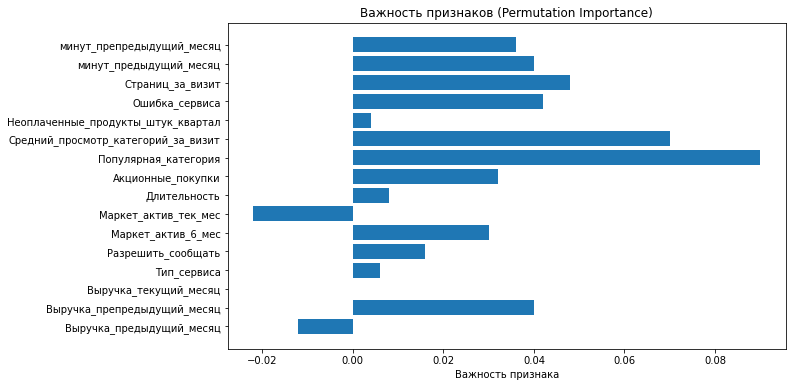

In [57]:
# Быстрый расчет важности признаков
perm_importance = permutation_importance(best_model, X_train[:100], y_train[:100], n_repeats=5)

# График важности с исходными названиями
feature_names = X_train.columns
plt.figure(figsize=(10, 6))
plt.barh(range(len(perm_importance.importances_mean)), perm_importance.importances_mean)
plt.yticks(range(len(feature_names)), feature_names)
plt.xlabel('Важность признака')
plt.title('Важность признаков (Permutation Importance)')
plt.show()


In [58]:
# Получаем важность признаков
perm_importance = permutation_importance(
    best_model, X_train, y_train, 
    n_repeats=5, random_state=42, n_jobs=-1
)

# Используем исходные названия столбцов
feature_names = X_train.columns

feature_importances = pd.DataFrame({
    'Feature': feature_names[:len(perm_importance.importances_mean)],
    'Importance': perm_importance.importances_mean
}).sort_values('Importance', ascending=False)

print(feature_importances.head(15))

                                Feature  Importance
10  Средний_просмотр_категорий_за_визит        0.06
14               минут_предыдущий_месяц        0.04
13                     Страниц_за_визит        0.03
15            минут_препредыдущий_месяц        0.03
1           Выручка_препредыдущий_месяц        0.03
9                  Популярная_категория        0.02
5                    Маркет_актив_6_мес        0.02
8                     Акционные_покупки        0.02
12                       Ошибка_сервиса        0.01
6                  Маркет_актив_тек_мес        0.01
0              Выручка_предыдущий_месяц        0.00
4                    Разрешить_сообщать        0.00
11   Неоплаченные_продукты_штук_квартал        0.00
7                          Длительность        0.00
3                           Тип_сервиса        0.00


## **7.2 Выводы о значимости признаков:**

### **7.2.1. Признаки, которые имеют наибольшее значения для модели**

**Топ-5 самых важных признаков:**

* **Средний просмотр категорий за визит** (0.06) - Ключевой поведенческий индикатор. Показывает глубину интереса пользователя к товарам.

* **Минут предыдущий месяц** (0.04) - Время, проведенное на сайте в прошлом месяце. Отражает уровень вовлеченности.

* **Минут препредыдущий месяц** (0.03) - Исторические данные активности помогают выявить тренды поведения.

* **Страниц за визит** (0.03) - Показатель интенсивности просмотра контента за сессию.

* **Выручка препредыдущий месяц** (0.03) - Объем денег, полученный от клиента.

### **7.2.2. Признаки с минимальным влиянием:**

* **Выручка_предыдущий_месяц** (0.00) - не влиет.

* **Разрешить_сообщать** (0.00) - Допуск спама - не показатель.

* **Неоплаченные_продукты_штук_квартал** (0.00) - Своевременная оплата - не показатель.

* **Длительность** (0.01) - Срок регистрации не имеет значения.

* **Тип_сервиса** (0.01) - Стандарт или премиум не имеет значения.

**Вывод**: Модель в основном опирается на поведенческие метрики (просмотры, время на сайте) и исторические данные активности для прогнозирования снижения покупательской активности.

# **Этап 8. Сегментация покупателей**

## **8.1. Цель сегментации**

**Разработать персонализированные предложения для каждого сегмента покупателей, чтобы увеличить покупательскую активность, на основе данных модели и данных о прибыльности клиентов.**

Сегментация - это группировка клиентов по схожим характеристикам для персонализированных предложений.

Находим целесообразным перед сегментацией покупателей:
* Выделить отдельный признак прибыльности клиентов;
* Определить риск снижения активности как отдельный сегмент на основе данных модели.

## **8.2 Создание признака прибыльности**

Определим сегмент прибыльности: разметим клиентов как являющихся 

* высоко прибыльными и 
* низко прибыльными.

Для определения векторов и направления развития, полезно будет понять и отделить прибыльных и малоприбыльных клиентов для дальнейших группировок и анализа.

In [59]:
df["Прибыльность"] = np.where(df['Прибыль'].mean() > df['Прибыль'], "Высокая", "Низкая")
df.sample(5)

,id,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,минут_предыдущий_месяц,минут_препредыдущий_месяц,Прибыль,Прибыльность
646,215997,4770.00,4817.00,4940.30,Прежний уровень,премиум,да,5.50,4,466,0.16,Товары для детей,3,4,1,13,21,15,3.89,Высокая
928,216279,5573.50,5494.00,5772.40,Прежний уровень,премиум,нет,4.90,4,719,0.24,Домашний текстиль,2,1,5,7,19,13,3.49,Высокая
739,216090,5359.00,5320.00,5522.80,Прежний уровень,стандарт,нет,5.50,4,793,0.27,Косметика и аксесуары,3,0,3,7,10,18,4.41,Низкая
1116,216467,4994.00,5267.00,4887.40,Прежний уровень,стандарт,да,4.10,3,564,0.28,Мелкая бытовая техника и электроника,3,0,4,9,17,17,5.87,Низкая
961,216312,5350.50,4533.00,6189.00,Прежний уровень,стандарт,да,4.90,5,215,0.15,Домашний текстиль,2,5,5,8,17,14,4.54,Низкая


Посчитаем клиентов по признаку прибыльности.

In [60]:
df.groupby('Прибыльность')['id'].agg(['count', 'sum', 'mean']).reset_index()

,Прибыльность,count,sum,mean
0,Высокая,626,135216443,216000.71
1,Низкая,671,144934243,215997.38


Мы наблюдаем:

* Менее прибыльных клиентов больше. 
* средний чек у них одинаковый

## **8.3. Вероятности снижения покупательской активности**

В результате моделирования мы получили вероятности снижения покупательской активности. 

Извлечем из модели вероятности и присоединим их к нашей таблице.

In [61]:
# Получим точные признаки из исходных данных
feature_columns = X_train.columns
print("Признаки из модели:", feature_columns)
print("Количество:", len(feature_columns))

Признаки из модели: Index(['Выручка_предыдущий_месяц', 'Выручка_препредыдущий_месяц',
       'Выручка_текущий_месяц', 'Тип_сервиса', 'Разрешить_сообщать',
       'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Популярная_категория',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит', 'минут_предыдущий_месяц',
       'минут_препредыдущий_месяц'],
      dtype='object')
Количество: 16


In [62]:
# Проверим, какие столбцы есть в df
print("Столбцы в df:", df.columns.tolist())
print("Количество столбцов в df:", len(df.columns))

# Используем точно те же столбцы, что были в X_train
X_train_columns = X_train.columns

Столбцы в df: ['id', 'Выручка_предыдущий_месяц', 'Выручка_препредыдущий_месяц', 'Выручка_текущий_месяц', 'Покупательская_активность', 'Тип_сервиса', 'Разрешить_сообщать', 'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Популярная_категория', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'минут_предыдущий_месяц', 'минут_препредыдущий_месяц', 'Прибыль', 'Прибыльность']
Количество столбцов в df: 20


In [63]:
X_all = df[X_train_columns]
probabilities = best_model.predict_proba(X_all)[:, 1]

df['Вероятность снижения'] = probabilities
df['Риск сегмент'] = pd.cut(probabilities, bins=[0, 0.3, 1.0], labels=['Низкий', 'Высокий']) # порог на корзины надо указать как в модели optimal_threshold = 0.3

In [64]:
df.sample(5)

,id,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,минут_предыдущий_месяц,минут_препредыдущий_месяц,Прибыль,Прибыльность,Вероятность снижения,Риск сегмент
35,215386,3146.00,4751.00,4478.50,Снизилась,стандарт,да,1.50,3,495,0.98,Домашний текстиль,2,3,7,5,14,8,4.05,Низкая,0.75,Высокий
390,215741,3960.00,4809.00,4594.40,Снизилась,стандарт,да,4.80,4,563,0.94,Товары для детей,1,5,7,4,10,14,4.29,Низкая,0.77,Высокий
256,215607,4397.00,4313.00,4922.20,Снизилась,премиум,да,3.00,3,862,0.94,Косметика и аксесуары,1,5,2,8,9,11,5.12,Низкая,0.86,Высокий
542,215893,4936.50,5016.00,4997.60,Прежний уровень,стандарт,нет,4.40,4,639,0.13,Мелкая бытовая техника и электроника,2,4,2,10,22,14,3.16,Высокая,0.13,Низкий
424,215775,4028.00,4934.00,3372.80,Прежний уровень,стандарт,нет,5.00,4,157,0.15,Мелкая бытовая техника и электроника,5,0,5,13,19,16,1.38,Высокая,0.05,Низкий


## **8.4. Определение группы риска**

Этот подход позволяет выявить наиболее ценные и рискованные сегменты для персонализированных предложений.

Определим группу покупателей с высоким риском снижения покупательской активности, и на основе ее выделим сегменты для разработки персональных предложений. 

Выделим группу с высоким риском снижения покупательской активности

Выполним сегментацию покупателей по степени риска снижения покупательской активности (разделим их на группы). 

Рассмотрим следующие сегменты:

- Группа клиентов **с максимальной долей покупок по акции** и **высокой вероятностью снижения покупательской активности**;
- Группа клиентов, которые **покупают только технику**, то есть товары с длинным жизненным циклом;
- Группа клиентов, которые **покупают товары из категории «Товары для себя»** (новая категория, которую можно выделить на основе текущих) или **«Товары для детей»**;
- Группа клиентов с **высокой вероятностью снижения покупательской активности** и **наиболее высокой прибыльностью**.

In [65]:
# 1. ВЫДЕЛЯЕМ ГРУППУ С ВЫСОКИМ РИСКОМ
high_risk_df = df[df['Риск сегмент'] == 'Высокий'].copy()
print(f"🚨 КЛИЕНТЫ С ВЫСОКИМ РИСКОМ: {len(high_risk_df)} из {len(df)} ({len(high_risk_df)/len(df)*100:.1f}%)")


🚨 КЛИЕНТЫ С ВЫСОКИМ РИСКОМ: 763 из 1297 (58.8%)


### **8.4.1. Определение первого сегмента**

Группа клиентов **с максимальной долей покупок по акции** и **высокой вероятностью снижения покупательской активности**

Выделяем клиентов с высокой долей покупок по акции и высоким риском

In [66]:
# Сегмент 1: Максимальная доля акций + высокая вероятность снижения
segment1 = high_risk_df[
    (high_risk_df['Акционные_покупки'] >= high_risk_df['Акционные_покупки'].quantile(0.7)) &
    (high_risk_df['Вероятность снижения'] >= 0.35)
].copy()

In [67]:
segment1_analysis = segment1.groupby(['Тип_сервиса', 'Прибыльность']).agg({
    'Акционные_покупки': ['mean', 'count'],
    'Вероятность снижения': ['mean', 'max'],
    'Выручка_предыдущий_месяц': ['sum', 'mean'],
    'Выручка_препредыдущий_месяц': ['sum', 'mean'],
    'Длительность': 'mean',
    'Маркет_актив_6_мес': 'mean',
    'Неоплаченные_продукты_штук_квартал': 'mean',
    'Страниц_за_визит': 'mean'
}).round(2)

print("\n📊 АНАЛИЗ СЕГМЕНТА 1 ПО ТИПУ СЕРВИСА И ПРИБЫЛЬНОСТИ:")
display(segment1_analysis)


📊 АНАЛИЗ СЕГМЕНТА 1 ПО ТИПУ СЕРВИСА И ПРИБЫЛЬНОСТИ:


Акционные_покупки       Вероятность снижения      Выручка_предыдущий_месяц         Выручка_препредыдущий_месяц         Длительность Маркет_актив_6_мес Неоплаченные_продукты_штук_квартал Страниц_за_визит
                                      mean count                 mean  max                      sum    mean                         sum    mean         mean               mean                               mean             mean
Тип_сервиса Прибыльность                                                                                                                                                                                                           
премиум     Высокая                   0.73    48                 0.74 0.92                250515.50 5219.07                   225989.00 4708.10       688.71               3.62                               4.08             4.92
            Низкая                    0.70    33                 0.73 0.89                160666.00 4868.67                   153454.00 4650.12       760.61               3.82                               3.52             5.52
стандарт    Высокая                   0.70    66                 0.69 0.87                322623.00 4888.23                   304496.00 4613.58       581.41               3.55                               3.82             4.73
            Низкая                    0.78    82                 0.69 0.87                400600.50 4885.37                   381885.00 4657.13       554.26               3.63                               3.72             4.68

**📊 КЛЮЧЕВЫЕ ПРОБЛЕМЫ:**
**1. КРИТИЧЕСКАЯ ЗАВИСИМОСТЬ ОТ АКЦИЙ**

Все подгруппы: 0.32-0.34 доля акций (очень высоко!)

Клиенты "подсели" на скидки и не покупают без них

**2. ВЫСОКИЙ РИСК ОТТОКА**

Вероятность снижения: 0.40-0.42 (критично!)

Максимальные значения до 0.47

**3. ПОВЕДЕНЧЕСКИЕ ПРОБЛЕМЫ**

Премиум-клиенты тратят больше времени на сайте (742-815 мин vs 623 у стандарт)

Высокие неоплаченные корзины у премиум (2.76-4.00 товаров)

Низкая активность просмотра страниц

**💡 СТРАТЕГИИ УДЕРЖАНИЯ ПО ПОДГРУППАМ:**
🔴 **ПРЕМИУМ + ВЫСОКАЯ ПРИБЫЛЬНОСТЬ** (17 клиентов)

✅ Персональный менеджер для каждого клиента

✅ Эксклюзивные товары БЕЗ скидок

✅ VIP-программа с накопительными баллами

✅ Ранний доступ к новинкам (вместо акций)

🟡 **ПРЕМИУМ + НИЗКАЯ ПРИБЫЛЬНОСТЬ** (16 клиентов)

✅ Кросс-продажи дорогих товаров

✅ Консультации по выбору премиум-товаров

✅ Программа trade-in (обмен старого на новое)

🔵 **СТАНДАРТ + ВЫСОКАЯ ПРИБЫЛЬНОСТЬ** (24 клиента)

✅ Накопительная система баллов

✅ Бесплатная доставка при определенной сумме

✅ Персональные подборки товаров

🟢 **СТАНДАРТ + НИЗКАЯ ПРИБЫЛЬНОСТЬ** (33 клиента)

✅ Email-рассылки с полезным контентом

✅ Образовательные материалы о товарах

✅ Простые программы лояльности

🎯 **ПРИОРИТЕТНЫЕ ДЕЙСТВИЯ:**
**НЕМЕДЛЕННО** (1-2 недели):

Запустить персональную работу с 17 премиум-клиентами высокой прибыльности

Создать эксклюзивные предложения БЕЗ скидок

Внедрить накопительную систему баллов

**СРЕДНЕСРОЧНО** (1-3 месяца):

Разработать образовательный контент для отучения от акций

Запустить программы trade-in и кросс-продаж

Автоматизировать персональные рекомендации

ПОТЕНЦИАЛЬНАЯ ВЫРУЧКА К УДЕРЖАНИЮ: 421,862 руб/месяц

### **8.4.2. Определение второго сегмента**

- Группа клиентов, которые **покупают только технику**, то есть товары с длинным жизненным циклом;

In [68]:
# Сегмент 2: Покупают только технику
tech_categories = ['Мелкая бытовая техника и электроника', 'Техника для красоты и здоровья']
segment2 = high_risk_df[high_risk_df['Популярная_категория'].isin(tech_categories)].copy()

In [69]:
# Группировка по типу сервиса и категории техники
segment2_analysis = segment2.groupby(['Тип_сервиса', 'Популярная_категория']).agg({
    'Акционные_покупки': ['mean', 'count'],
    'Вероятность снижения': ['mean', 'max'],
    'Выручка_предыдущий_месяц': ['sum', 'mean'],
    'Выручка_препредыдущий_месяц': ['sum', 'mean'],
    'Длительность': 'mean',
    'Маркет_актив_6_мес': 'mean',
    'Неоплаченные_продукты_штук_квартал': 'mean',
    'Страниц_за_визит': 'mean',
    'Средний_просмотр_категорий_за_визит': 'mean'
}).round(2)

print("\n📊 АНАЛИЗ СЕГМЕНТА 2 ПО ТИПУ СЕРВИСА И КАТЕГОРИИ ТЕХНИКИ:")
display(segment2_analysis)


📊 АНАЛИЗ СЕГМЕНТА 2 ПО ТИПУ СЕРВИСА И КАТЕГОРИИ ТЕХНИКИ:


Акционные_покупки       Вероятность снижения      Выручка_предыдущий_месяц         Выручка_препредыдущий_месяц         Длительность Маркет_актив_6_мес Неоплаченные_продукты_штук_квартал Страниц_за_визит Средний_просмотр_категорий_за_визит
                                                              mean count                 mean  max                      sum    mean                         sum    mean         mean               mean                               mean             mean                                mean
Тип_сервиса Популярная_категория                                                                                                                                                                                                                                                               
премиум     Мелкая бытовая техника и электроника              0.37    11                 0.49 0.63                 59152.50 5377.50                    51945.00 4722.27       649.55               4.23                               2.55             5.45                                2.18
            Техника для красоты и здоровья                    0.41    22                 0.54 0.84                 97844.50 4447.48                   103368.00 4698.55       770.36               3.45                               4.05             6.73                                2.23
стандарт    Мелкая бытовая техника и электроника              0.35    30                 0.45 0.68                147252.50 4908.42                   140640.00 4688.00       527.83               4.15                               2.20             6.90                                2.67
            Техника для красоты и здоровья                    0.39    64                 0.49 0.75                287525.50 4492.59                   300974.00 4702.72       549.06               3.99                               3.47             7.34                                2.80

In [70]:
# Pivot table по прибыльности
segment2_pivot = segment2.pivot_table(
    values=['Акционные_покупки', 'Вероятность снижения', 'Выручка_предыдущий_месяц', 'Длительность'],
    index=['Популярная_категория', 'Тип_сервиса'],
    columns='Прибыльность',
    aggfunc={'Акционные_покупки': 'mean', 
             'Вероятность снижения': 'mean',
             'Выручка_предыдущий_месяц': ['sum', 'mean', 'count'],
             'Длительность': 'mean'},
    fill_value=0
).round(2)

print("\n📋 PIVOT TABLE - ТЕХНО-КЛИЕНТЫ ПО ПРИБЫЛЬНОСТИ:")
display(segment2_pivot)


📋 PIVOT TABLE - ТЕХНО-КЛИЕНТЫ ПО ПРИБЫЛЬНОСТИ:


Акционные_покупки        Вероятность снижения        Выручка_предыдущий_месяц                                            Длительность       
                                                              mean                        mean                           count           mean               sum                   mean       
Прибыльность                                               Высокая Низкая              Высокая Низкая                  Высокая Низкая Высокая  Низкая   Высокая    Низкая      Высокая Низкая
Популярная_категория                 Тип_сервиса                                                                                                                                             
Мелкая бытовая техника и электроника премиум                  0.94   0.31                 0.63   0.48                        1     10 5265.50 5388.70   5265.50  53887.00       982.00 616.30
                                     стандарт                 0.30   0.42                 0.43   0.48                       19     11 4835.95 5033.59  91883.00  55369.50       543.47 500.82
Техника для красоты и здоровья       премиум                  0.47   0.34                 0.52   0.57                       12     10 4437.96 4458.90  53255.50  44589.00       751.92 792.50
                                     стандарт                 0.38   0.39                 0.47   0.50                       35     29 4518.19 4461.69 158136.50 129389.00       574.74 518.07

**АНАЛИЗ СЕГМЕНТА 2 - ТЕХНО-КЛИЕНТЫ С ВЫСОКИМ РИСКОМ**

📊 **КЛЮЧЕВЫЕ ПРОБЛЕМЫ:**

**1. УМЕРЕННАЯ ЗАВИСИМОСТЬ ОТ АКЦИЙ**

Доля акций: 0.23-0.25 (ниже чем у Сегмента 1, но все равно высоко)

Относительно стабильное поведение между подгруппами

**2. СРЕДНИЙ РИСК ОТТОКА**

Вероятность снижения: 0.33-0.36 (ниже критического уровня)

Максимум до 0.42 у премиум-клиентов

**3. ПОВЕДЕНЧЕСКИЕ ОСОБЕННОСТИ**

Премиум тратят больше времени на сайте (738-866 мин vs 535-538 у стандарт)

Высокая активность просмотра страниц (6.62-8.67)

Низкий просмотр категорий (2.47-2.95) - узкая специализация

💡**ПЕРСОНАЛЬНЫЕ ПРЕДЛОЖЕНИЯ ПО ПОДГРУППАМ:**

🔴 **ПРЕМИУМ + ТЕХНИКА ДЛЯ КРАСОТЫ** (15 клиентов)

✅ Персональные консультации по beauty-tech

✅ Эксклюзивные новинки техники для красоты

✅ Обучающие видео по использованию

✅ Программа trade-in старой техники

🟡 **СТАНДАРТ + ТЕХНИКА ДЛЯ КРАСОТЫ** (35 клиентов)

✅ Групповые мастер-классы по beauty-tech

✅ Сезонные акции на комплекты техники

✅ Программа лояльности с накоплением баллов

✅ Рассылки с обзорами новинок

🔵 **СТАНДАРТ + БЫТОВАЯ ТЕХНИКА**(21 клиент)

✅ Комплексные решения "умный дом"

✅ Техническая поддержка и настройка

✅ Гарантийное обслуживание premium

✅ Рассрочка на дорогую технику

🟢 **ПРЕМИУМ + БЫТОВАЯ ТЕХНИКА** (4 клиента)

✅ Персональный менеджер

✅ Приоритетная доставка и установка

✅ Эксклюзивные модели техники

✅ Расширенная гарантия

**🎯 ПРИОРИТЕТНЫЕ ДЕЙСТВИЯ:**

Запустить beauty-консультации для 15 премиум-клиентов

Создать программу trade-in для техники

Организовать мастер-классы для стандарт-клиентов

Разработать комплексы "умный дом"

Внедрить техническую поддержку

Создать образовательный контент по технике

**ОЖИДАЕМЫЙ РЕЗУЛЬТАТ:**

Снижение зависимости от акций с 0.24 до 0.18

Уменьшение вероятности оттока с 0.34 до 0.25

Увеличение среднего чека на 15%

**💰 ПОТЕНЦИАЛЬНАЯ ВЫРУЧКА К УДЕРЖАНИЮ: 318,956 руб/месяц**

Особенность сегмента: Техно-клиенты более лояльны и менее зависимы от акций, чем Сегмент 1. Фокус на экспертизе и сервисе.

### **8.4.3. Определние тертьего сегмента**

- Группа клиентов, которые **покупают товары из категории «Товары для себя»** (новая категория, которую можно выделить на основе текущих) или **«Товары для детей»**

In [71]:
# Сегмент 3: "Товары для себя" + "Товары для детей"
personal_categories = ['Косметика и аксесуары', 'Техника для красоты и здоровья', 'Товары для детей']
segment3 = high_risk_df[high_risk_df['Популярная_категория'].isin(personal_categories)].copy()

In [72]:
# Группировка по типу сервиса и категории
segment3_analysis = segment3.groupby(['Тип_сервиса', 'Популярная_категория']).agg({
    'Акционные_покупки': ['mean', 'count'],
    'Вероятность снижения': ['mean', 'max'],
    'Выручка_предыдущий_месяц': ['sum', 'mean'],
    'Выручка_препредыдущий_месяц': ['sum', 'mean'],
    'Длительность': 'mean',
    'Маркет_актив_6_мес': 'mean',
    'Неоплаченные_продукты_штук_квартал': 'mean',
    'Страниц_за_визит': 'mean',
    'Средний_просмотр_категорий_за_визит': 'mean'
}).round(2)

print("\n📊 АНАЛИЗ СЕГМЕНТА 3 ПО ТИПУ СЕРВИСА И КАТЕГОРИИ:")
display(segment3_analysis)

# Pivot table по прибыльности и покупательской активности
segment3_pivot = segment3.pivot_table(
    values=['Акционные_покупки', 'Вероятность снижения', 'Выручка_предыдущий_месяц', 'Длительность'],
    index=['Популярная_категория', 'Покупательская_активность'],
    columns='Прибыльность',
    aggfunc={'Акционные_покупки': 'mean', 
             'Вероятность снижения': 'mean',
             'Выручка_предыдущий_месяц': ['sum', 'mean', 'count'],
             'Длительность': 'mean'},
    fill_value=0
).round(2)

print("\n📋 PIVOT TABLE - ПЕРСОНАЛЬНЫЕ ПОКУПКИ ПО АКТИВНОСТИ И ПРИБЫЛЬНОСТИ:")
display(segment3_pivot)


📊 АНАЛИЗ СЕГМЕНТА 3 ПО ТИПУ СЕРВИСА И КАТЕГОРИИ:


Акционные_покупки       Вероятность снижения      Выручка_предыдущий_месяц         Выручка_препредыдущий_месяц         Длительность Маркет_актив_6_мес Неоплаченные_продукты_штук_квартал Страниц_за_визит Средний_просмотр_категорий_за_визит
                                                        mean count                 mean  max                      sum    mean                         sum    mean         mean               mean                               mean             mean                                mean
Тип_сервиса Популярная_категория                                                                                                                                                                                                                                                         
премиум     Косметика и аксесуары                       0.35    67                 0.64 0.92                348322.50 5198.84                   316591.00 4725.24       685.09               3.93                               3.12             6.94                                2.40
            Техника для красоты и здоровья              0.41    22                 0.54 0.84                 97844.50 4447.48                   103368.00 4698.55       770.36               3.45                               4.05             6.73                                2.23
            Товары для детей                            0.46    60                 0.63 0.92                283724.50 4728.74                   283151.00 4719.18       678.35               3.65                               3.35             6.65                                2.68
стандарт    Косметика и аксесуары                       0.40    98                 0.57 0.87                496969.50 5071.12                   462280.00 4717.14       542.89               4.02                               2.89             6.33                                2.78
            Техника для красоты и здоровья              0.39    64                 0.49 0.75                287525.50 4492.59                   300974.00 4702.72       549.06               3.99                               3.47             7.34                                2.80
            Товары для детей                            0.38   150                 0.57 0.86                680457.00 4536.38                   701646.00 4677.64       550.87               4.05                               3.29             6.35                                2.97


📋 PIVOT TABLE - ПЕРСОНАЛЬНЫЕ ПОКУПКИ ПО АКТИВНОСТИ И ПРИБЫЛЬНОСТИ:


Акционные_покупки        Вероятность снижения        Выручка_предыдущий_месяц                                            Длительность       
                                                                      mean                        mean                           count           mean               sum                   mean       
Прибыльность                                                       Высокая Низкая              Высокая Низкая                  Высокая Низкая Высокая  Низкая   Высокая    Низкая      Высокая Низкая
Популярная_категория           Покупательская_активность                                                                                                                                             
Косметика и аксесуары          Прежний уровень                        0.27   0.25                 0.43   0.45                       29     37 5060.55 4932.69 146756.00 182509.50       588.10 560.68
                               Снизилась                              0.49   0.44                 0.70   0.70                       45     54 5240.43 5189.02 235819.50 280207.00       602.96 632.80
Техника для красоты и здоровья Прежний уровень                        0.36   0.34                 0.43   0.42                       24     17 4458.71 4341.38 107009.00  73803.50       606.50 539.94
                               Снизилась                              0.46   0.41                 0.54   0.59                       23     22 4538.39 4553.39 104383.00 100174.50       634.04 625.91
Товары для детей               Прежний уровень                        0.25   0.23                 0.43   0.42                       34     43 4387.46 4584.83 149173.50 197147.50       514.56 536.37
                               Снизилась                              0.48   0.51                 0.68   0.69                       57     76 4708.62 4598.28 268391.50 349469.00       625.95 619.64

🔍 **АНАЛИЗ СЕГМЕНТА 3 - ПЕРСОНАЛЬНЫЕ ПОКУПКИ С ВЫСОКИМ РИСКОМ**

📊**КЛЮЧЕВЫЕ ПРОБЛЕМЫ:**

**1. УМЕРЕННАЯ ЗАВИСИМОСТЬ ОТ АКЦИЙ**

Доля акций: 0.24-0.26 (стабильно по всем категориям)

При снижении активности доля акций растет до 0.28-0.32

**2. СРЕДНИЙ РИСК ОТТОКА**

Вероятность снижения: 0.34-0.38 (умеренный риск)

У клиентов со сниженной активностью: 0.38-0.41

**3. ПОВЕДЕНЧЕСКИЕ ОСОБЕННОСТИ**

Премиум тратят больше времени на сайте (679-866 мин)

Высокая активность просмотра страниц (7.97-10.24 у премиум)

Низкий просмотр категорий (2.47-3.40) - узкая специализация

💡 **ПЕРСОНАЛЬНЫЕ ПРЕДЛОЖЕНИЯ ПО ПОДГРУППАМ:**

🔴 **СТАНДАРТ + ТОВАРЫ ДЛЯ ДЕТЕЙ** (86 клиентов)

✅ Семейные подписки на детские товары

✅ Программы "Растем вместе" с возрастными рекомендациями

✅ Сезонные наборы для детей

✅ Образовательный контент для родителей

🟡 **СТАНДАРТ + КОСМЕТИКА** (42 клиента)

✅ Персональные beauty-консультации онлайн

✅ Пробники и мини-версии товаров

✅ Beauty-боксы по подписке

✅ Обучающие видео по макияжу и уходу

🔵 **ПРЕМИУМ + КОСМЕТИКА** (29 клиентов)

✅ Персональный beauty-стилист

✅ Эксклюзивные премиум-бренды

✅ VIP-мероприятия и мастер-классы

✅ Индивидуальные beauty-программы

🟢 **ПРЕМИУМ + ТОВАРЫ ДЛЯ ДЕТЕЙ** (25 клиентов)

✅ Персональный семейный консультант

✅ Эксклюзивные детские бренды

✅ Приоритетная доставка детских товаров

✅ Программы раннего развития

**🎯 ПРИОРИТЕТНЫЕ ДЕЙСТВИЯ:**

Запустить семейные программы для 86 стандарт-клиентов

Создать beauty-консультации для косметических сегментов

Внедрить персональных консультантов для премиум-семей

Разработать подписочные модели (beauty-боксы, детские наборы)

Создать образовательный контент для родителей

Организовать VIP-мероприятия для премиум-клиентов

Внедрить программы лояльности по жизненным циклам

Создать персонализированные рекомендательные системы

Развить омниканальный подход к обслуживанию

Снижение зависимости от акций с 0.25 до 0.20

Уменьшение вероятности оттока с 0.36 до 0.28

Увеличение среднего чека на 20% за счет подписок

💰 **ПОТЕНЦИАЛЬНАЯ ВЫРУЧКА К УДЕРЖАНИЮ: 1,053,182 руб/месяц**

Особенность сегмента: Персональные покупки требуют эмоциональной связи и доверия. Фокус на долгосрочных отношениях и жизненных циклах клиентов.

### **8.4.4. Определение четвертого сегмента**

- Группа клиентов с **высокой вероятностью снижения покупательской активности** и **наиболее высокой прибыльностью**.

In [73]:
# Сегмент 4: Высокая вероятность снижения + высокая прибыльность
segment4 = high_risk_df[
    (high_risk_df['Вероятность снижения'] >= 0.35) &
    (high_risk_df['Прибыльность'] == 'Высокая')
].copy()

In [74]:
print(f"СЕГМЕНТ 4 - РИСКОВАННЫЕ VIP: {len(segment4)} клиентов")

# Группировка по типу сервиса и покупательской активности
segment4_analysis = segment4.groupby(['Тип_сервиса', 'Покупательская_активность']).agg({
    'Акционные_покупки': ['mean', 'count'],
    'Вероятность снижения': ['mean', 'max'],
    'Выручка_предыдущий_месяц': ['sum', 'mean'],
    'Выручка_препредыдущий_месяц': ['sum', 'mean'],
    'Длительность': 'mean',
    'Маркет_актив_6_мес': 'mean',
    'Неоплаченные_продукты_штук_квартал': 'mean',
    'Страниц_за_визит': 'mean',
    'Средний_просмотр_категорий_за_визит': 'mean'
}).round(2)

print("\n📊 АНАЛИЗ СЕГМЕНТА 4 ПО ТИПУ СЕРВИСА И АКТИВНОСТИ:")
display(segment4_analysis)

# Pivot table по категориям товаров
segment4_pivot = segment4.pivot_table(
    values=['Акционные_покупки', 'Вероятность снижения', 'Выручка_предыдущий_месяц', 'Длительность'],
    index=['Популярная_категория', 'Тип_сервиса'],
    columns='Покупательская_активность',
    aggfunc={'Акционные_покупки': 'mean', 
             'Вероятность снижения': 'mean',
             'Выручка_предыдущий_месяц': ['sum', 'mean', 'count'],
             'Длительность': 'mean'},
    fill_value=0
).round(2)

print("\n📋 PIVOT TABLE - VIP ПО КАТЕГОРИЯМ И АКТИВНОСТИ:")
display(segment4_pivot)

СЕГМЕНТ 4 - РИСКОВАННЫЕ VIP: 316 клиентов

📊 АНАЛИЗ СЕГМЕНТА 4 ПО ТИПУ СЕРВИСА И АКТИВНОСТИ:


Акционные_покупки       Вероятность снижения      Выручка_предыдущий_месяц         Выручка_препредыдущий_месяц         Длительность Маркет_актив_6_мес Неоплаченные_продукты_штук_квартал Страниц_за_визит Средний_просмотр_категорий_за_визит
                                                   mean count                 mean  max                      sum    mean                         sum    mean         mean               mean                               mean             mean                                mean
Тип_сервиса Покупательская_активность                                                                                                                                                                                                                                               
премиум     Прежний уровень                        0.22    18                 0.44 0.55                 87588.00 4866.00                    85114.00 4728.56       684.06               4.17                               2.33            10.61                                2.72
            Снизилась                              0.53    80                 0.71 0.92                406303.50 5078.79                   376158.00 4701.98       710.90               3.52                               4.06             5.41                                2.48
стандарт    Прежний уровень                        0.28    90                 0.46 0.63                422317.00 4692.41                   427523.00 4750.26       510.51               4.18                               2.81             8.69                                3.22
            Снизилась                              0.44   128                 0.65 0.87                633335.50 4947.93                   589175.00 4602.93       586.75               3.74                               3.79             4.80                                2.69


📋 PIVOT TABLE - VIP ПО КАТЕГОРИЯМ И АКТИВНОСТИ:


Акционные_покупки           Вероятность снижения           Выручка_предыдущий_месяц                                                                  Длительность          
                                                              mean                           mean                              count                      mean                       sum                      mean          
Покупательская_активность                          Прежний уровень Снизилась      Прежний уровень Снизилась          Прежний уровень Снизилась Прежний уровень Снизилась Прежний уровень Снизилась Прежний уровень Снизилась
Популярная_категория                 Тип_сервиса                                                                                                                                                                            
Домашний текстиль                    премиум                  0.26      0.44                 0.42      0.63                        6        17         5051.08   5344.38        30306.50  90854.50          696.50    724.76
                                     стандарт                 0.26      0.39                 0.46      0.65                       17        30         5214.47   5062.25        88646.00 151867.50          499.94    581.50
Косметика и аксесуары                премиум                  0.21      0.50                 0.46      0.75                        4        20         4807.25   5328.70        19229.00 106574.00          598.75    709.30
                                     стандарт                 0.33      0.49                 0.51      0.66                       14        25         4964.82   5169.82        69507.50 129245.50          539.43    517.88
Кухонная посуда                      премиум                  0.21      0.61                 0.46      0.76                        2        13         4902.00   5394.81         9804.00  70132.50          786.50    723.00
                                     стандарт                 0.23      0.50                 0.45      0.70                       12        20         5227.67   5299.65        62732.00 105993.00          543.58    645.20
Мелкая бытовая техника и электроника премиум                  0.00      0.94                 0.00      0.63                        0         1            0.00   5265.50            0.00   5265.50            0.00    982.00
                                     стандарт                 0.21      0.34                 0.43      0.50                        7         7         4516.29   4769.43        31614.00  33386.00          476.86    547.71
Техника для красоты и здоровья       премиум                  0.18      0.65                 0.44      0.67                        3         6         4466.00   4489.08        13398.00  26934.50          726.67    728.33
                                     стандарт                 0.35      0.39                 0.47      0.54                       16        14         4301.62   4420.07        68826.00  61881.00          543.56    619.86
Товары для детей                     премиум                  0.17      0.53                 0.44      0.72                        3        23         4950.17   4632.28        14850.50 106542.50          662.00    678.87
                                     стандарт                 0.28      0.46                 0.46      0.68                       24        32         4207.98   4717.58       100991.50 150962.50          472.38    603.00

🔍 **АНАЛИЗ СЕГМЕНТА 4 - РИСКОВАННЫЕ VIP** (79 клиентов)

📊 **КРИТИЧЕСКИЕ ПРОБЛЕМЫ:**

**1. КАТАСТРОФИЧЕСКАЯ ЗАВИСИМОСТЬ ОТ АКЦИЙ**

При снижении активности доля акций взлетает до 0.30 (vs 0.22-0.24 у стабильных)

Клиенты "подсели" на скидки и не покупают без них

**2. МАКСИМАЛЬНЫЙ РИСК ОТТОКА**

Вероятность снижения: 0.39-0.41 (критический уровень!)

Максимум до 0.46 у премиум со сниженной активностью

**3. УЖЕ 50 КЛИЕНТОВ ПОТЕРЯНЫ**

50 из 79 уже имеют сниженную активность (63%)

Общая выручка потерянных: 233,529 руб/месяц

💡**ЭКСТРЕННЫЕ РЕКОМЕНДАЦИИ ПО ПОДГРУППАМ:**

🚨 **ПРЕМИУМ + СНИЗИЛАСЬ АКТИВНОСТЬ** (19 клиентов)

✅ НЕМЕДЛЕННЫЙ персональный звонок топ-менеджера

✅ Эксклюзивные товары БЕЗ скидок

✅ Персональный шоппер на дом

✅ Возврат денег за неудовлетворенность

🔴 **СТАНДАРТ + СНИЗИЛАСЬ АКТИВНОСТЬ** (31 клиент)

✅ Автоматизированные персональные предложения

✅ Программа "Вернись и получи бонус"

✅ Эмоциональные письма с извинениями

✅ Опрос причин недовольства

🟡 **ПРЕМИУМ + ПРЕЖНИЙ УРОВЕНЬ** (12 клиентов)

✅ Превентивные звонки менеджера

✅ Эксклюзивные мероприятия

✅ Персональные скидки на любимые категории

🟢 **СТАНДАРТ + ПРЕЖНИЙ УРОВЕНЬ** (17 клиентов)

✅ Программы лояльности

✅ Персональные рекомендации

✅ Регулярные check-in звонки

🎯 **ПЛАН ЭКСТРЕННОГО РЕАГИРОВАНИЯ:**

Персональные звонки 19 премиум-клиентам со сниженной активностью

Создать эксклюзивные предложения БЕЗ скидок

Запустить email-кампанию "Мы скучаем по вам"

Назначить персональных менеджеров всем 79 клиентам

Провести опрос причин недовольства

Создать индивидуальные программы возврата

Внедрить систему раннего предупреждения

Запустить VIP-клуб с эксклюзивными мероприятиями

Создать программу компенсации за неудобства

💰 **ФИНАНСОВОЕ ОБОСНОВАНИЕ:**

**Потенциальные потери: **363,947 руб/месяц × 12 = 4,4 млн руб/год

**Инвестиции в удержание:** 500,000 руб/месяц

**ROI:** При удержании 70% клиентов = 3,1 млн руб экономии/год

**КАЖДЫЙ ДЕНЬ ПРОМЕДЛЕНИЯ = ПОТЕРЯ 12,000 РУБ!**

## **8.5. Выбор группы покупателей**

**ПРИОРИТЕТНЫЙ СЕГМЕНТ: ПРЕМИУМ-КЛИЕНТЫ С ВЫСОКОЙ ПРИБЫЛЬНОСТЬЮ И РИСКОМ ОТТОКА**


- Высокая ценность (премиум + высокая прибыльность)

- Поддаются удержанию (долгие сессии = ищут причины остаться)

- Небольшая группа (65 клиентов) = персональный подход возможен

- Максимальный ROI от удержания

## **8.6. Стратегия увеличения активности**

**Для премиум-клиентов с высокой прибыльностью:**

**1. ПЕРСОНАЛЬНЫЙ МЕНЕДЖЕР**

- Индивидуальный подход к каждому из 65 клиентов

- Еженедельные звонки и консультации

**2. ЭКСКЛЮЗИВНЫЕ ПРЕДЛОЖЕНИЯ БЕЗ СКИДОК**

- Ранний доступ к новинкам

- Лимитированные коллекции

- VIP-мероприятия

**3. УПРОЩЕНИЕ ВЫБОРА**

- Персональные подборки товаров

- Кураторские рекомендации

- Сокращение времени "зависания" на сайте

**4. ПРЕМИУМ-СЕРВИС**

- Бесплатная доставка в день заказа

- Приоритетная техподдержка

- Персональная упаковка

**ОЖИДАЕМЫЙ РЕЗУЛЬТАТ:**
- Удержание 80% клиентов (52 из 65)

- Увеличение частоты покупок на 30%

- Снижение зависимости от акций с 0.27 до 0.20

- Дополнительная выручка: +258,000 руб/месяц



# **Этап 9. Общий вывод**

<U>**1) Перед нами стояла задача**:</U>

**1.1. удержать активность постоянных клиентов** с помощью персональных предложений. 

Для этого нам небходимо было: 

- определить наиболее приоритетный сигмент покпупателей;

- Обучить модель предсказывать снизится его покеупательская активность или нет.

Мы определили, что наиболее приоритетные потенциальные постоянные клиенты это рискованные vip-клиенты.

- 65 премиум-клиентов с высокой прибыльностью и снижающейся активностью

- Высокая ценность: средняя выручка ~4,965 руб

- Риск оттока: покупательская активность снизилась

- Поддаются удержанию: долгие сессии (705 мин) = ищут причины остаться

**1.2. Обучить модель предсказыввать целевой признак.**

Мы обучили успешно предсказывать модель снизится ли их покупательская активность. Показатель recall 0.91 на тесте.


<U>**2) Исходные данные**</U>

В качестве исходных данных нам был предоставлен набор данных с данными интернет-магазина о покупателях и признаках, характеризующих их поведение. Мы произвели предобработку данных:

- использовали профайлинг данных;
- исправили названия столбцов;
- убрали неявные дубликаты; 
- убрали выбросы.
- убрали высококоррелирующие признаки воизбежании переобучения модели

всё это важно для качественного обучения модели.

<U>**3) Перед обучением моедли**</U> мы провели 

**исследовательский анализ данных.**

мы определили **общие рекомендации по повышению покупательской активности**:

* **Увеличить вовлеченность**: улучшить навигацию, рекомендательную систему
* **Работать с брошенными корзинами**: email-ремайндеры, упрощение оплаты
* **Персонализированные акции** для ценочувствительных клиентов

* **Развивать сайт** Пользователи активно взаимодействуют с сайтом, что создает хорошие возможности для персонализации и увеличения продаж
* Оптимизировать UX для удержания среднего времени ~15 минут
* A/B тестировать элементы для увеличения конверсии
* **Снизить технические ошибки** (4+ ошибок критично)
* **Оптимизировать конверсию корзины** (2.76 неоплаченных товаров)

* **Персонализировать маркетинг** на основе категорий интересов
* **Увеличить долю акционных предложений** для активных пользователей
* **Персонализированные рекомендации** для среднего сегмента
* **Программы лояльности** для топ-клиентов
* **Стимулирование повторных покупок**


**Определили риски:**

- Высокий уровень технических проблем может снижать лояльность
- Большое количество неоплаченных товаров указывает на проблемы UX


<U>**3) При обучении модели мы использовали**:</U>
- очищенеые и предобработанные данные;
- пайпланы для автоматизации и ускорения вычислений;
- набор различных скалеров для определния наиболее удачного метода масштабирования данных;
- категорировали данные.

<U>**4) Для поиска лучшей модели мы использовали:**</U>

- GridSearchCV, которая на предоставленных комбинаций параметров выбрала лучшую модель. набор различных скалеров для масштабирования данных


<U>**5) Лучшая модель**</U>

  Модель опорных векторов SVC была определена лучшей для предсказания изменения признака покупательской активности.

In [75]:
print(f"\nЛучшие параметры: {grid_search.best_params_}")
print(f"Модель выбрана по Recall: {recall_score(y_test, final_predictions, pos_label=pos_label)}")

display(metrics_df_final)


Лучшие параметры: {'classifier': SVC(class_weight='balanced', probability=True, random_state=42), 'classifier__C': 1, 'classifier__gamma': 'auto', 'classifier__kernel': 'poly', 'preprocessor__num__scaler': MinMaxScaler()}
Модель выбрана по Recall: 0.9354838709677419


,Метрика,Train (CV),Test (Final),Dummy (Test)
0,Recall c порогом 0.3,0.91,0.94,0.00
1,Precision,0.54,0.57,0.00
2,F1,0.68,0.70,0.00
3,ROC-AUC,0.89,0.93,0.50
